# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020

# №1. Загрузка данных 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import lightgbm as lgb
import phik
import shap
shap.initjs()

In [2]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve ,log_loss, confusion_matrix,accuracy_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from IPython.display import display
from phik.report import plot_correlation_matrix
from catboost import Pool
plt.style.use('dark_background')

In [3]:
phone = pd.read_csv('/Users/armineagajanyan/Downloads/final_provider/phone.csv')
contract = pd.read_csv('/Users/armineagajanyan/Downloads/final_provider/contract.csv')
personal = pd.read_csv('/Users/armineagajanyan/Downloads/final_provider/personal.csv')
internet = pd.read_csv('/Users/armineagajanyan/Downloads/final_provider/internet.csv')

In [4]:
#создадим функцию для информации
def table_info(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    display(df.isna().mean())
    return df

# Датасет phone

In [5]:
table_info(phone)    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

customerID       0.0
MultipleLines    0.0
dtype: float64

customerID MultipleLines
0     5575-GNVDE            No
1     3668-QPYBK            No
2     9237-HQITU            No
3     9305-CDSKC           Yes
4     1452-KIOVK           Yes
...          ...           ...
6356  2569-WGERO            No
6357  6840-RESVB           Yes
6358  2234-XADUH           Yes
6359  8361-LTMKD           Yes
6360  3186-AJIEK            No

[6361 rows x 2 columns]

In [6]:
phone.isna().mean()

customerID       0.0
MultipleLines    0.0
dtype: float64

In [7]:
phone['MultipleLines'].value_counts().to_frame()

MultipleLines
No            3390
Yes           2971


Вывод 
- customerID -уникальный идентификатор клиента
- MultipleLines - наличие нескольких телефонных линий у клиента

- датасет phone содержит 2 столбца и 6361 строк
- пропущенных значений нет
- у 2971 клиента есть нескольких телефонных линий    

# Датасет contract

In [8]:
table_info(contract)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0                 Yes           Electronic check           29.85        29.85  
1                  No               Mailed check           56.95       1889.5  
2                 Yes               Mailed check           53.85       108.15  
3                  No  Bank transfer (automatic)           42.30      1840.75  
4                 Yes           Electronic check           70.70       151.65  
...               ...                        ...             ...          ...  
7038              Yes               Mailed check           84.80       1990.5  
7039              Yes    Credit card (automatic)          103.20       7362.9  
7040              Yes           Electronic check           29.60       346.45  
7041              Yes               Mailed check           74.40        306.6  
7042              Yes  Bank transfer (automatic)          105.65       6844.5  

[7043 rows x 8 columns]

In [9]:
contract['BeginDate'].value_counts().to_frame().head(20)

BeginDate
2014-02-01        366
2019-10-01        237
2019-11-01        237
2019-09-01        237
2020-01-01        233
2019-12-01        220
2014-03-01        178
2019-07-01        156
2019-08-01        146
2019-06-01        141
2019-02-01        128
2019-05-01        123
2019-01-01        114
2014-04-01        114
2019-03-01        110
2019-04-01        108
2018-08-01        100
2018-09-01        100
2018-11-01         99
2014-07-01         98

In [10]:
contract['EndDate'].value_counts().to_frame()

EndDate
No                      5174
2019-11-01 00:00:00      485
2019-12-01 00:00:00      466
2020-01-01 00:00:00      460
2019-10-01 00:00:00      458

In [11]:
contract['Type'].value_counts().to_frame()

Type
Month-to-month  3875
Two year        1695
One year        1473

In [12]:
contract['PaperlessBilling'].value_counts().to_frame()

PaperlessBilling
Yes              4171
No               2872

In [13]:
contract['PaymentMethod'].value_counts().to_frame()

PaymentMethod
Electronic check                    2365
Mailed check                        1612
Bank transfer (automatic)           1544
Credit card (automatic)             1522

<AxesSubplot:>

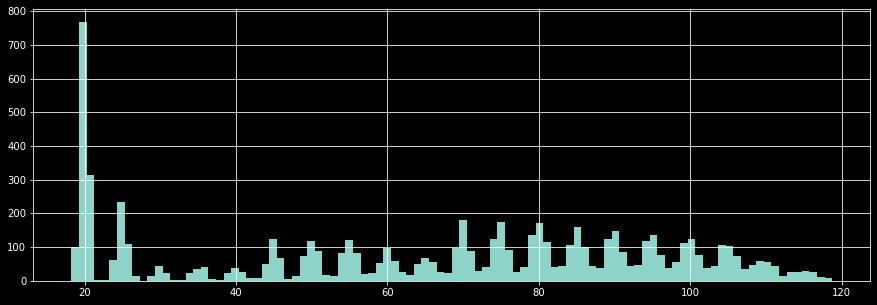

In [14]:
contract['MonthlyCharges'].hist(bins = 100,figsize = (15, 5))

<AxesSubplot:>

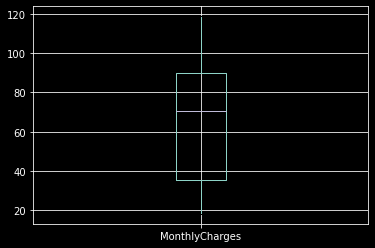

In [15]:
contract.boxplot(column=['MonthlyCharges'])

In [16]:
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [17]:
contract['TotalCharges'].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

Вывод
- датасет contract содержит 8 столбцов и 7043 строк
- пропущенных значений нет
- по слобцу 'MonthlyCharges'  среднее:64.76, медиана:70.35
- тип данных в столбцах  'BeginDate', 'EndDate' нужно менять datetime64, а в столбце 'TotalCharges' на float64
- с сентября 2019 года 17% клинетов подключили услугу, возможно была акция
- с октября 2019 года расторгнули 27% клиентов 
- у 55% клиентов договор ежемесячно, а годовые или двухгодовые договоры почти одинаково заключают
- 59% клиентов предпочитают получить электронный счет
- клиенты наличними не платят

- customerID - уникальный идентификатор клиента
- BeginDate - дата начала подключения к оператору
- EndDate - дата окончания договора
- Type - тип оплаты по договору: ежемесячно, годовой или двухгодовой
- PaperlessBilling - электронный счет
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячный платёж тарифа
- TotalCharges -  итоговая сумма за все время


# Датасет personal

In [18]:
table_info(personal)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

customerID  gender  SeniorCitizen Partner Dependents
0     7590-VHVEG  Female              0     Yes         No
1     5575-GNVDE    Male              0      No         No
2     3668-QPYBK    Male              0      No         No
3     7795-CFOCW    Male              0      No         No
4     9237-HQITU  Female              0      No         No
...          ...     ...            ...     ...        ...
7038  6840-RESVB    Male              0     Yes        Yes
7039  2234-XADUH  Female              0     Yes        Yes
7040  4801-JZAZL  Female              0     Yes        Yes
7041  8361-LTMKD    Male              1     Yes         No
7042  3186-AJIEK    Male              0      No         No

[7043 rows x 5 columns]

In [19]:
personal['gender'].value_counts().to_frame()

gender
Male      3555
Female    3488

In [20]:
personal['SeniorCitizen'].value_counts().to_frame()

SeniorCitizen
0           5901
1           1142

In [21]:
personal['Partner'].value_counts().to_frame()

Partner
No      3641
Yes     3402

In [22]:
personal['Dependents'].value_counts().to_frame()

Dependents
No         4933
Yes        2110

Вывод
- датасет personal содержит 5 столбцов и 7043 строк
- пропущенных значений нет
- в датасете мужчины и женщины в одинаковом количестве 
- 16% старше 60 лет
- почти половина состоит в браке
- у 30% клиентов есть иждивенцы

- customerID - уникальный идентификатор клиента
- gender - пол клиента 
- SeniorCitizen - клиент пожилой или нет (старше 60 лет https://www.consultant.ru/law/podborki/vozrast_pozhilogo_cheloveka/?ysclid=l4wjdb3xz6720426625)
- Partner - клиент в браке или нет
- Dependents - наличие иждивенцев


# Датасет internet

In [23]:
table_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingTV StreamingMovies  
0             No          No              No  
1             No          No              No  
2             No          No              No  
3            Yes          No              No  
4             No          No              No  
...          ...         ...             ...  
5512         Yes         Yes             Yes  
5513          No         Yes             Yes  
5514          No          No              No  
5515          No          No              No  
5516         Yes         Yes             Yes  

[5517 rows x 8 columns]

In [24]:
internet['InternetService'].value_counts().to_frame()

InternetService
Fiber optic             3096
DSL                     2421

In [25]:
internet['OnlineSecurity'].value_counts().to_frame()

OnlineSecurity
No             3498
Yes            2019

In [26]:
internet['OnlineBackup'].value_counts().to_frame()

OnlineBackup
No           3088
Yes          2429

In [27]:
internet['DeviceProtection'].value_counts().to_frame()

DeviceProtection
No               3095
Yes              2422

In [28]:
internet['TechSupport'].value_counts().to_frame()

TechSupport
No          3473
Yes         2044

In [29]:
internet['StreamingTV'].value_counts().to_frame()

StreamingTV
No          2810
Yes         2707

In [30]:
internet['StreamingMovies'].value_counts().to_frame()

StreamingMovies
No              2785
Yes             2732


Вывод
- датасет personal содержит 8 столбцов и 5517 строк
- пропущенных значений нет
- 3096 клиентов предпочитают тип подключения интернета оптоволокно 
- у 2019 есть услуга блокировки небезопасных сайтов
- у 2429 есть услуга облачного хранилища для создания резервных копий
- у 2422 есть услуга антивируса
- у 2044 есть услуга технической поддержки
- у 2707 есть услуги онлайн-телевидения
- у 2732 есть услуги онлайн-кинотеатра


- customerID - уникальный идентификатор клиента
- InternetService - тип подключения интернета (DSL, оптоволокно)
- OnlineSecurity - наличие услуги блокировки небезопасных сайтов
- OnlineBackup - наличие облачного хранилища для создания резервных копий
- DeviceProtection - наличие услуги антивируса
- TechSupport - наличие выделенной линии технической поддержки
- StreamingTV - наличие услуги онлайн-телевидения
- StreamingMovies - наличие услуги онлайн-кинотеатра.

Общие выводы
1. Датасет phone
- customerID -уникальный идентификатор клиента
- MultipleLines - наличие нескольких телефонных линий у клиента

- датасет phone содержит 2 столбца и 6361 строк
- пропущенных значений нет
- у 2971 клиента есть нескольких телефонных линий 

2. Датасет contract
- датасет contract содержит 8 столбцов и 7043 строк
- пропущенных значений нет
- по слобцу 'MonthlyCharges'  среднее:64.76, медиана:70.35
- тип данных в столбцах  'BeginDate', 'EndDate' нужно менять datetime64, а в столбце 'TotalCharges' на float64
- с сентября 2019 года 17% клинетов подключили услугу, возможно была акция
- с октября 2019 года расторгнули 27% клиентов 
- у 55% клиентов договор ежемесячно, а годовые или двухгодовые договоры почти одинаково заключают
- 59% клиентов предпочитают получить электронный счет
- клиенты наличними не платят

- customerID - уникальный идентификатор клиента
- BeginDate - дата начала подключения к оператору
- EndDate - дата окончания договора
- Type - тип оплаты по договору: ежемесячно, годовой или двухгодовой
- PaperlessBilling - электронный счет
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячный платёж тарифа
- TotalCharges -  итоговая сумма за все время
3. Датасет personal

- датасет personal содержит 5 столбцов и 7043 строк
- пропущенных значений нет
- в датасете мужчины и женщины в одинаковом количестве 
- 16% старше 60 лет
- почти половина состоит в браке
- у 30% клиентов есть иждивенцы

- customerID - уникальный идентификатор клиента
- gender - пол клиента 
- SeniorCitizen - клиент пожилой или нет (старше 60 лет https://www.consultant.ru/law/podborki/vozrast_pozhilogo_cheloveka/?ysclid=l4wjdb3xz6720426625)
- Partner - клиент в браке или нет
- Dependents - наличие иждивенцев
4. Датасет internet
- датасет personal содержит 8 столбцов и 5517 строк
- пропущенных значений нет
- 3096 клиентов предпочитают тип подключения интернета оптоволокно 
- у 2019 есть услуга блокировки небезопасных сайтов
- у 2429 есть услуга облачного хранилища для создания резервных копий
- у 2422 есть услуга антивируса
- у 2044 есть услуга технической поддержки
- у 2707 есть услуги онлайн-телевидения
- у 2732 есть услуги онлайн-кинотеатра


- customerID - уникальный идентификатор клиента
- InternetService - тип подключения интернета (DSL, оптоволокно)
- OnlineSecurity - наличие услуги блокировки небезопасных сайтов
- OnlineBackup - наличие облачного хранилища для создания резервных копий
- DeviceProtection - наличие услуги антивируса
- TechSupport - наличие выделенной линии технической поддержки
- StreamingTV - наличие услуги онлайн-телевидения
- StreamingMovies - наличие услуги онлайн-кинотеатра.



# №2. Предобработка данных

In [31]:
#объединяем четыре датасета в один датасет по customerID
df = contract.merge(personal, on = 'customerID', how = 'left').merge(phone, on = 'customerID', how = 'left').merge(internet, on = 'customerID', how = 'left')


In [32]:
#посмотрим новую таблицу
df.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

   gender  SeniorCitizen Partner Dependents MultipleLines InternetService  \
0  Female              0     Yes         No           NaN             DSL   
1    Male              0      No         No            No             DSL   
2    Male              0      No         No            No             DSL   
3    Male              0      No         No           NaN             DSL   
4  Female              0      No         No            No     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies  
0              No  
1              No  
2              No  
3              No  
4              No

In [33]:
#проверим дубликаты
'Количество дубликатов:', df.duplicated().sum()

('Количество дубликатов:', 0)

In [34]:
#приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [35]:
#приведем названия столбцов к snake case
df.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperlessbilling',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup', 'deviceprotection',
       'techsupport', 'streaming_tv', 'streaming_movies']

In [36]:
df.head()

customer_id  begin_date             end_date            type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperlessbilling             payment_method  monthly_charges total_charges  \
0              Yes           Electronic check            29.85         29.85   
1               No               Mailed check            56.95        1889.5   
2              Yes               Mailed check            53.85        108.15   
3               No  Bank transfer (automatic)            42.30       1840.75   
4              Yes           Electronic check            70.70        151.65   

   gender  seniorcitizen partner dependents multiple_lines internet_service  \
0  Female              0     Yes         No            NaN              DSL   
1    Male              0      No         No             No              DSL   
2    Male              0      No         No             No              DSL   
3    Male              0      No         No            NaN              DSL   
4  Female              0      No         No             No      Fiber optic   

  online_security online_backup deviceprotection techsupport streaming_tv  \
0              No           Yes               No          No           No   
1             Yes            No              Yes          No           No   
2             Yes           Yes               No          No           No   
3             Yes            No              Yes         Yes           No   
4              No            No               No          No           No   

  streaming_movies  
0               No  
1               No  
2               No  
3               No  
4               No

In [37]:
#в категориальных признаках поменяем 1 при признаке 'Yes' и 0 при признаке 'No'
df_binar = ['paperlessbilling', 'partner', 'dependents', 'online_security', 'online_backup', 'deviceprotection',
            'techsupport', 'streaming_tv', 'streaming_movies', 'multiple_lines']
# cоздадим функцию, возвращающую 1 при признаке 'Yes' и 0 при признаке 'No'
def one_zero(binar):
    if binar == 'Yes':
        return 1
    elif binar == 'No':
        return 0

# применим функцию ко всем бинарным столбцам
for col in df_binar:
    df[col] = df[col].apply(one_zero)

In [38]:
df.head(3)

customer_id  begin_date             end_date            type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   

   paperlessbilling    payment_method  monthly_charges total_charges  gender  \
0                 1  Electronic check            29.85         29.85  Female   
1                 0      Mailed check            56.95        1889.5    Male   
2                 1      Mailed check            53.85        108.15    Male   

   seniorcitizen  partner  dependents  multiple_lines internet_service  \
0              0        1           0             NaN              DSL   
1              0        0           0             0.0              DSL   
2              0        0           0             0.0              DSL   

   online_security  online_backup  deviceprotection  techsupport  \
0              0.0            1.0               0.0          0.0   
1              1.0            0.0               1.0          0.0   
2              1.0            1.0               0.0          0.0   

   streaming_tv  streaming_movies  
0           0.0               0.0  
1           0.0               0.0  
2           0.0               0.0

In [39]:
#проверим пропуски
df.isna().mean()

customer_id         0.000000
begin_date          0.000000
end_date            0.000000
type                0.000000
paperlessbilling    0.000000
payment_method      0.000000
monthly_charges     0.000000
total_charges       0.000000
gender              0.000000
seniorcitizen       0.000000
partner             0.000000
dependents          0.000000
multiple_lines      0.096834
internet_service    0.216669
online_security     0.216669
online_backup       0.216669
deviceprotection    0.216669
techsupport         0.216669
streaming_tv        0.216669
streaming_movies    0.216669
dtype: float64

In [40]:
#заполним пропуски в категориальных признаков -1 (поставим заглушку)
for column in ['online_security', 'online_backup', 
               'deviceprotection', 'techsupport', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
     df[column].fillna(-1, inplace=True)       

In [41]:
#заполним пропуски в столбце 'internet_service' no_info (чтобы потом с призноком легче было работать)
df['internet_service'] = df['internet_service'].fillna('no_info')

In [42]:
# поменяем тип данных float64 на int8
for col in ['online_security', 'online_backup', 
               'deviceprotection', 'techsupport', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
    df[col] = df[col].astype('int8')   

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       7043 non-null   object 
 1   begin_date        7043 non-null   object 
 2   end_date          7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   int64  
 5   payment_method    7043 non-null   object 
 6   monthly_charges   7043 non-null   float64
 7   total_charges     7043 non-null   object 
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   int64  
 11  dependents        7043 non-null   int64  
 12  multiple_lines    7043 non-null   int8   
 13  internet_service  7043 non-null   object 
 14  online_security   7043 non-null   int8   
 15  online_backup     7043 non-null   int8   
 16  deviceprotection  7043 non-null   int8   


In [44]:
df.head()

customer_id  begin_date             end_date            type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

   paperlessbilling             payment_method  monthly_charges total_charges  \
0                 1           Electronic check            29.85         29.85   
1                 0               Mailed check            56.95        1889.5   
2                 1               Mailed check            53.85        108.15   
3                 0  Bank transfer (automatic)            42.30       1840.75   
4                 1           Electronic check            70.70        151.65   

   gender  seniorcitizen  partner  dependents  multiple_lines  \
0  Female              0        1           0              -1   
1    Male              0        0           0               0   
2    Male              0        0           0               0   
3    Male              0        0           0              -1   
4  Female              0        0           0               0   

  internet_service  online_security  online_backup  deviceprotection  \
0              DSL                0              1                 0   
1              DSL                1              0                 1   
2              DSL                1              1                 0   
3              DSL                1              0                 1   
4      Fiber optic                0              0                 0   

   techsupport  streaming_tv  streaming_movies  
0            0             0                 0  
1            0             0                 0  
2            0             0                 0  
3            1             0                 0  
4            0             0                 0

In [45]:
#посмотрим день выгрузки данных:'2020-02-01'
df[df['begin_date'] == '2020-02-01']

customer_id  begin_date end_date      type  paperlessbilling  \
488   4472-LVYGI  2020-02-01       No  Two year                 1   
753   3115-CZMZD  2020-02-01       No  Two year                 0   
936   5709-LVOEQ  2020-02-01       No  Two year                 0   
1082  4367-NUYAO  2020-02-01       No  Two year                 0   
1340  1371-DWPAZ  2020-02-01       No  Two year                 0   
3331  7644-OMVMY  2020-02-01       No  Two year                 0   
3826  3213-VVOLG  2020-02-01       No  Two year                 0   
4380  2520-SGTTA  2020-02-01       No  Two year                 0   
5218  2923-ARZLG  2020-02-01       No  One year                 1   
6670  4075-WKNIU  2020-02-01       No  Two year                 0   
6754  2775-SEFEE  2020-02-01       No  Two year                 1   

                 payment_method  monthly_charges total_charges  gender  \
488   Bank transfer (automatic)            52.55                Female   
753                Mailed check            20.25                  Male   
936                Mailed check            80.85                Female   
1082               Mailed check            25.75                  Male   
1340    Credit card (automatic)            56.05                Female   
3331               Mailed check            19.85                  Male   
3826               Mailed check            25.35                  Male   
4380               Mailed check            20.00                Female   
5218               Mailed check            19.70                  Male   
6670               Mailed check            73.35                Female   
6754  Bank transfer (automatic)            61.90                  Male   

      seniorcitizen  partner  dependents  multiple_lines internet_service  \
488               0        1           1              -1              DSL   
753               0        0           1               0          no_info   
936               0        1           1               0              DSL   
1082              0        1           1               1          no_info   
1340              0        1           1              -1              DSL   
3331              0        1           1               0          no_info   
3826              0        1           1               1          no_info   
4380              0        1           1               0          no_info   
5218              0        1           1               0          no_info   
6670              0        1           1               1              DSL   
6754              0        0           1               1              DSL   

      online_security  online_backup  deviceprotection  techsupport  \
488                 1              0                 1            1   
753                -1             -1                -1           -1   
936                 1              1                 1            0   
1082               -1             -1                -1           -1   
1340                1              1                 1            1   
3331               -1             -1                -1           -1   
3826               -1             -1                -1           -1   
4380               -1             -1                -1           -1   
5218               -1             -1                -1           -1   
6670                0              1                 1            1   
6754                1              1                 0            1   

      streaming_tv  streaming_movies  
488              1                 0  
753             -1                -1  
936              1                 1  
1082            -1                -1  
1340             1                 0  
3331            -1                -1  
3826            -1                -1  
4380            -1                -1  
5218            -1                -1  
6670             1                 0  
6754             0                 0

In [46]:
# посмотрим сколько провелов в столбце 'total_charges'
(df['total_charges'] ==' ').value_counts()

False    7032
True       11
Name: total_charges, dtype: int64

In [47]:
#пробели 11 штук можно удалить
df = df.loc[df['total_charges'] !=' ']

In [48]:
len(df)

7032

In [49]:
# поменяем тип данных от object на float64
df['total_charges'] = df['total_charges'].astype('float64')

In [50]:
#создадим целевой признак
df['churn'] = 'client_left'
df.loc[df['end_date'] == 'No', 'churn'] = 'still_client'

In [51]:
# проверим дисбаланс классов
df['churn'].value_counts(normalize=True)

still_client    0.734215
client_left     0.265785
Name: churn, dtype: float64

In [52]:
#изменим тип данных begin_date на datetime
df['begin_date'] = pd.to_datetime(df['begin_date'], format = '%Y-%m-%d')


In [53]:
#изменим тип данных end_date на datetime
#заменим  в столбце 'end_date' если 'No' (дейстующий договор) заменим на день выгрузки '2020-02-01'
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'
df['end_date'] = pd.to_datetime(df['end_date'],format='%Y.%m.%d')

In [54]:
df.head(5)

customer_id begin_date   end_date            type  paperlessbilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month                 1   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                 0   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month                 1   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                 0   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month                 1   

              payment_method  monthly_charges  total_charges  gender  \
0           Electronic check            29.85          29.85  Female   
1               Mailed check            56.95        1889.50    Male   
2               Mailed check            53.85         108.15    Male   
3  Bank transfer (automatic)            42.30        1840.75    Male   
4           Electronic check            70.70         151.65  Female   

   seniorcitizen  ...  dependents  multiple_lines  internet_service  \
0              0  ...           0              -1               DSL   
1              0  ...           0               0               DSL   
2              0  ...           0               0               DSL   
3              0  ...           0              -1               DSL   
4              0  ...           0               0       Fiber optic   

  online_security  online_backup  deviceprotection  techsupport  streaming_tv  \
0               0              1                 0            0             0   
1               1              0                 1            0             0   
2               1              1                 0            0             0   
3               1              0                 1            1             0   
4               0              0                 0            0             0   

   streaming_movies         churn  
0                 0  still_client  
1                 0  still_client  
2                 0   client_left  
3                 0  still_client  
4                 0   client_left  

[5 rows x 21 columns]

In [55]:
#добавляем столбец lifetime: дейсвие договора в днях, иначе 'продолжительность жизни клиента' 
#для этого создадим признаки с годом и месяцем
df['begin_contract_year'] = pd.DatetimeIndex(df['begin_date']).year
df['end_contract_year'] = pd.DatetimeIndex(df['end_date']).year
df['begin_contract_month'] = pd.DatetimeIndex(df['begin_date']).month
df['end_contract_month'] = pd.DatetimeIndex(df['end_date']).month

#добавляем столбец lifetime: дейсвие договора в месяцах
df['lifetime'] = (df['end_contract_year'] - df['begin_contract_year']) * 365 + (df['end_contract_month']
                - df['begin_contract_month']) * 30


#удаляем лишние столбцы     
df = df.drop(['end_contract_month'], axis=1)#'begin_contract_year','end_contract_year','begin_contract_month' 

In [56]:
df.head()

customer_id begin_date   end_date            type  paperlessbilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month                 1   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                 0   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month                 1   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                 0   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month                 1   

              payment_method  monthly_charges  total_charges  gender  \
0           Electronic check            29.85          29.85  Female   
1               Mailed check            56.95        1889.50    Male   
2               Mailed check            53.85         108.15    Male   
3  Bank transfer (automatic)            42.30        1840.75    Male   
4           Electronic check            70.70         151.65  Female   

   seniorcitizen  ...  online_backup  deviceprotection  techsupport  \
0              0  ...              1                 0            0   
1              0  ...              0                 1            0   
2              0  ...              1                 0            0   
3              0  ...              0                 1            1   
4              0  ...              0                 0            0   

  streaming_tv  streaming_movies         churn  begin_contract_year  \
0            0                 0  still_client                 2020   
1            0                 0  still_client                 2017   
2            0                 0   client_left                 2019   
3            0                 0  still_client                 2016   
4            0                 0   client_left                 2019   

   end_contract_year  begin_contract_month  lifetime  
0               2020                     1        30  
1               2020                     4      1035  
2               2019                    10        60  
3               2020                     5      1370  
4               2019                     9        60  

[5 rows x 25 columns]

In [57]:
#приведем датасет к нижнему регистру
df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)


In [58]:
df.head()

customer_id begin_date   end_date            type  paperlessbilling  \
0  7590-vhveg 2020-01-01 2020-02-01  month-to-month                 1   
1  5575-gnvde 2017-04-01 2020-02-01        one year                 0   
2  3668-qpybk 2019-10-01 2019-12-01  month-to-month                 1   
3  7795-cfocw 2016-05-01 2020-02-01        one year                 0   
4  9237-hqitu 2019-09-01 2019-11-01  month-to-month                 1   

              payment_method  monthly_charges  total_charges  gender  \
0           electronic check            29.85          29.85  female   
1               mailed check            56.95        1889.50    male   
2               mailed check            53.85         108.15    male   
3  bank transfer (automatic)            42.30        1840.75    male   
4           electronic check            70.70         151.65  female   

   seniorcitizen  ...  online_backup  deviceprotection  techsupport  \
0              0  ...              1                 0            0   
1              0  ...              0                 1            0   
2              0  ...              1                 0            0   
3              0  ...              0                 1            1   
4              0  ...              0                 0            0   

  streaming_tv  streaming_movies         churn  begin_contract_year  \
0            0                 0  still_client                 2020   
1            0                 0  still_client                 2017   
2            0                 0   client_left                 2019   
3            0                 0  still_client                 2016   
4            0                 0   client_left                 2019   

   end_contract_year  begin_contract_month  lifetime  
0               2020                     1        30  
1               2020                     4      1035  
2               2019                    10        60  
3               2020                     5      1370  
4               2019                     9        60  

[5 rows x 25 columns]

In [59]:
#проверим пропуски
df.isna().mean()

customer_id             0.0
begin_date              0.0
end_date                0.0
type                    0.0
paperlessbilling        0.0
payment_method          0.0
monthly_charges         0.0
total_charges           0.0
gender                  0.0
seniorcitizen           0.0
partner                 0.0
dependents              0.0
multiple_lines          0.0
internet_service        0.0
online_security         0.0
online_backup           0.0
deviceprotection        0.0
techsupport             0.0
streaming_tv            0.0
streaming_movies        0.0
churn                   0.0
begin_contract_year     0.0
end_contract_year       0.0
begin_contract_month    0.0
lifetime                0.0
dtype: float64

In [60]:
#cоздадим новый признак, где можно посмотреть сколько клиентов на какие услуги подключились
df['services'] = 'all_services '
df.loc[df['multiple_lines'] == -1, 'services'] = 'internet_services' 
df.loc[df['internet_service'] == -1,'services'] = 'phone_services' 
df.head()

customer_id begin_date   end_date            type  paperlessbilling  \
0  7590-vhveg 2020-01-01 2020-02-01  month-to-month                 1   
1  5575-gnvde 2017-04-01 2020-02-01        one year                 0   
2  3668-qpybk 2019-10-01 2019-12-01  month-to-month                 1   
3  7795-cfocw 2016-05-01 2020-02-01        one year                 0   
4  9237-hqitu 2019-09-01 2019-11-01  month-to-month                 1   

              payment_method  monthly_charges  total_charges  gender  \
0           electronic check            29.85          29.85  female   
1               mailed check            56.95        1889.50    male   
2               mailed check            53.85         108.15    male   
3  bank transfer (automatic)            42.30        1840.75    male   
4           electronic check            70.70         151.65  female   

   seniorcitizen  ...  deviceprotection  techsupport  streaming_tv  \
0              0  ...                 0            0             0   
1              0  ...                 1            0             0   
2              0  ...                 0            0             0   
3              0  ...                 1            1             0   
4              0  ...                 0            0             0   

  streaming_movies         churn  begin_contract_year  end_contract_year  \
0                0  still_client                 2020               2020   
1                0  still_client                 2017               2020   
2                0   client_left                 2019               2019   
3                0  still_client                 2016               2020   
4                0   client_left                 2019               2019   

   begin_contract_month  lifetime           services  
0                     1        30  internet_services  
1                     4      1035      all_services   
2                    10        60      all_services   
3                     5      1370  internet_services  
4                     9        60      all_services   

[5 rows x 26 columns]

Вывод

- объединили четыре датасета в один датасет по customerID
- заполнили пропущенные значения 
- приводили столбцы и таблицу к нижнему регистру
- столбце total_charges удалили 11 строк с пробелами 
- поменяли к нужнему тип данных
- добавили новые столбцы 
  -  churn - клиент ушел или нет (целевой признак)
  -  lifetime - сколько в днях дейсвует договор
  -  services - наличие услуги у клиента (интернет, звонок или звонок и интернет) 


# №3. Исследовательский анализ данных

- Корреляция Фика: 
- посмотрим нелинейнную зависимомость между признакамы

In [61]:
#корреляция Фика (нелинейнная зависимомость между признакамы)
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['paperlessbilling', 'monthly_charges', 'total_charges', 'seniorcitizen', 'partner', 'dependents', 'multiple_lines', 'online_security', 'online_backup', 'deviceprotection', 'techsupport', 'streaming_tv', 'streaming_movies', 'begin_contract_year', 'end_contract_year', 'begin_contract_month', 'lifetime']


The number of unique values of variable customer_id is large: 7032. Are you sure this is not an interval variable? Analysis for pairs of variables including customer_id can be slow.


In [62]:
#важность признаков в датасете 
phik_overview['churn'].sort_values(ascending=False)

customer_id             1.000000
end_date                1.000000
churn                   1.000000
begin_date              0.507721
lifetime                0.473761
payment_method          0.448559
monthly_charges         0.359623
begin_contract_year     0.351127
paperlessbilling        0.295194
total_charges           0.280973
dependents              0.252268
type                    0.251283
begin_contract_month    0.249812
seniorcitizen           0.232897
partner                 0.232215
online_security         0.211583
techsupport             0.208763
internet_service        0.195860
online_backup           0.177165
deviceprotection        0.170500
streaming_movies        0.139368
streaming_tv            0.139025
multiple_lines          0.021870
gender                  0.000000
services                0.000000
end_contract_year            NaN
Name: churn, dtype: float64

На отток клиенты больше всего влияют: 
- lifetime: длительность договора
- payment_method: способ оплаты 
- monthly_charges: 'Ежемесячная' оплата
- paperlessbilling: способ получения счета
- total_charges: общая сумма оплаты
- dependents: наличия иждевенца
- type: тип договора


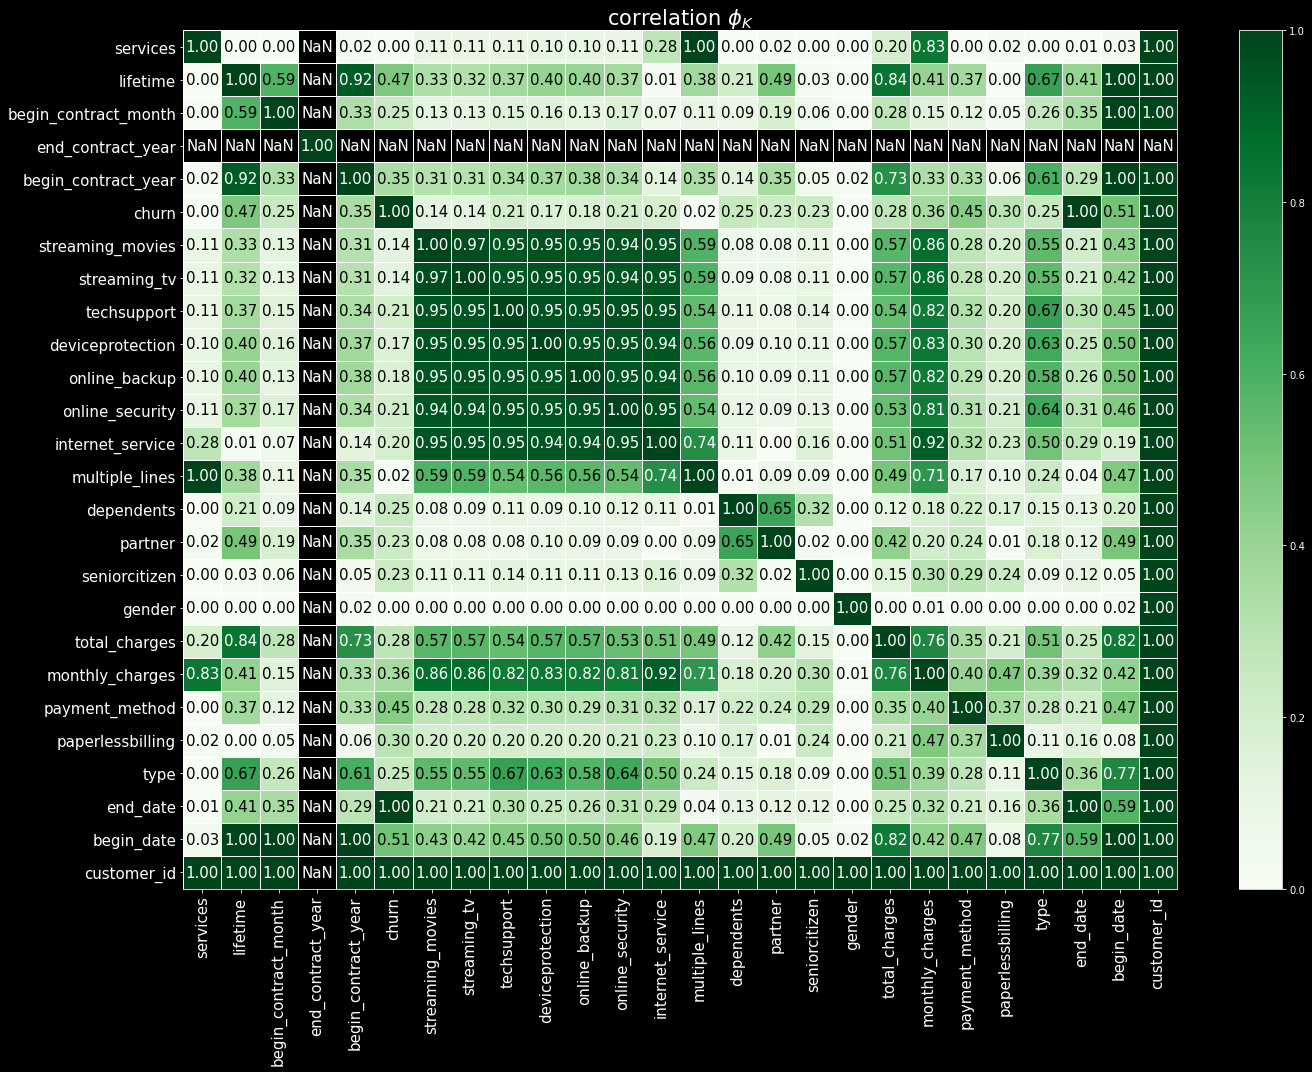

In [63]:
# матрицу зависимости прзнаков (Корреляция Фика)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 15))
plt.tight_layout()

Вывод
Корреляция Фика между признаками можно посмотреть в таблице
- из таблицы видно,что выручка зависит от подключенных услуг: корреляция Фика больше 0,82 
- сильная связь есть между 'monthly_charges'и 'total_charges': корреляция Фика 0.76
- интерсно заметить, что сильная связь есть между дополнительнимы  услугами: корреляция Фика больше 0.94, услуги подключаются вместе 
- тип договора коррелирует с подключенными услугами: корреляция Фика больше 0.50, возможно клиенту предлагают дополнительные услуги 
- наличия партнера зависит от признака наличия иждивенцов: корреляция Фика больше 0.65, возможно есть много домохозяек


In [64]:
# посмотрим значения числовых признаков 
df[['monthly_charges','total_charges','lifetime']].describe()

monthly_charges  total_charges     lifetime
count      7032.000000    7032.000000  7032.000000
mean         64.798208    2283.300441   987.283134
std          30.085974    2266.771362   746.663119
min          18.250000      18.800000    30.000000
25%          35.587500     401.450000   270.000000
50%          70.350000    1397.475000   885.000000
75%          89.862500    3794.737500  1675.000000
max         118.750000    8684.800000  2190.000000

- в столбце 'total_charges' среднее: 2283 и  медиана: 1397 сильно отличаются, возможно аномальные значения есть 
- в столбцах monthly_charges минимальные и максимальные значения сильно отличаются  

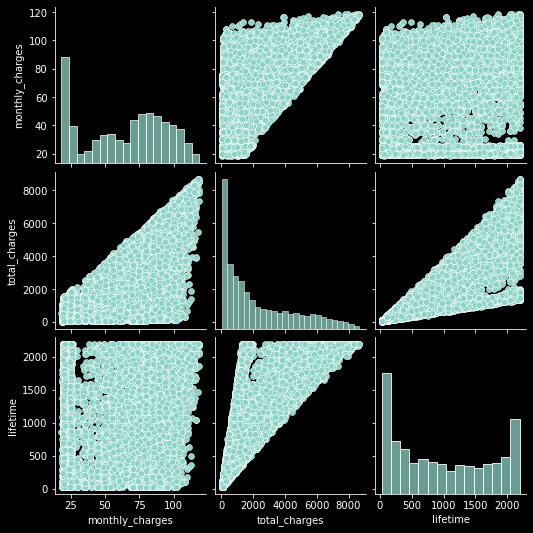

In [65]:
# построим графики
sns.pairplot(df[['monthly_charges', 'total_charges', 'lifetime']])
#корреляция Пирсона
df[['monthly_charges', 'total_charges', 'lifetime']].corr().style.background_gradient()

- Корреляция Пирсона больше 0.82 между 'total_charges' и 'lifetime'
- сильная связь есть между 'monthly_charges'и 'total_charges', корреляция Пирсона 0.65


Посмотрим отток клиентов по типу договора 

<AxesSubplot:title={'center':'Уход клиентов по типу договора'}, xlabel='type'>

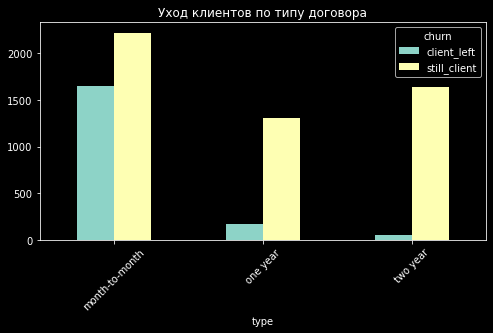

In [66]:
(
   df
    .pivot_table(index = 'type', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиентов по типу договора', rot=45)
)

Вывод
- из графика видно 
- больше всего уходят те клиенты, у которых тип оплаты по договору: 'Ежемесячно'
- второе местоe у тех, у кого тип оплаты 'Годовой'
- а меньше всего уходят клиенты, у которых тип оплаты по договору 'Двухгодовой' 

Text(0, 0.5, 'Выручка')

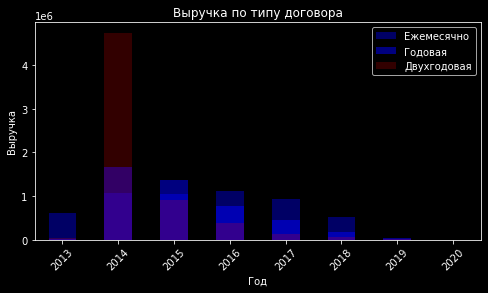

In [67]:
#построим графики 
df_type_month=(df
     .query('type=="month-to-month"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc='sum')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Ежемесячно', alpha=0.4, rot=45,color='b')# grid=True,
)
df_type_one_year=(df
     .query('type=="one year"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc='sum')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Годовая',color='b',alpha=0.5,rot=45, ax=df_type_month)
)

df_type_two_year=(df
     .query('type=="two year"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc='sum')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Двухгодовая',color='r',alpha=0.2,rot=45, ax=df_type_one_year)
)
plt.title('Выручка по типу договора')
plt.xlabel('Год')
plt.ylabel('Выручка')


Вывод
- из графика видно,что выручка снижается по всем типам договора оплаты за все время.

In [68]:
#построим сводные таблицы
df_type_month=(df
     .query('type=="month-to-month"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)
df_type_one_year=(df
     .query('type=="one year"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)

df_type_two_year=(df
     .query('type=="two year"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)                  

In [69]:
df_type_month.columns =['sum','count','median','mean','var','std','max','min']
df_type_month

sum  count    median         mean           var  \
begin_contract_year                                                           
2014                  607876.10    102  6252.375  5959.569608  1.635466e+06   
2015                 1061975.95    232  4835.225  4577.482543  1.451352e+06   
2016                 1056218.05    316  3543.200  3342.462184  1.126805e+06   
2017                 1117523.85    496  2359.775  2253.072278  6.526058e+05   
2018                  924345.25    740  1248.325  1249.115203  2.768049e+05   
2019                  529329.15   1765   206.600   299.903201  7.168726e+04   
2020                    8593.15    224    27.450    38.362277  4.287658e+02   

                             std      max      min  
begin_contract_year                                 
2014                 1278.853242  8061.50  1182.55  
2015                 1204.720733  7132.15  1087.25  
2016                 1061.510754  5315.10   717.30  
2017                  807.840206  3810.55   460.25  
2018                  526.122549  2686.05   233.55  
2019                  267.744775  1334.45    18.85  
2020                   20.706662    95.85    18.85

Вывод
- из таблицы можно сделать вывод, что количество заключенных договоров по типу  'Ежемесячно' растет и достигает пика в 2019 году, а 2020 год не полный. Несмотря на рост заключенных договоров, выручка уменьшается.

In [70]:
df_type_one_year.columns = ['sum','count','median','mean','var','std','max','min']
df_type_one_year

sum  count    median         mean           var  \
begin_contract_year                                                           
2013                    8684.80      1  8684.800  8684.800000           NaN   
2014                 1653717.50    292  6117.575  5663.416096  3.223678e+06   
2015                 1362012.50    327  4475.900  4165.175841  2.663689e+06   
2016                  763227.00    267  2908.200  2858.528090  1.764751e+06   
2017                  459300.45    250  1947.150  1837.201800  8.597598e+05   
2018                  179162.55    203   711.950   882.574138  2.939258e+05   
2019                   40749.85    125   233.900   325.998800  7.289536e+04   
2020                     198.85      7    20.200    28.407143  4.113429e+02   

                             std      max      min  
begin_contract_year                                 
2013                         NaN  8684.80  8684.80  
2014                 1795.460426  8309.55  1193.55  
2015                 1632.081185  7365.70   928.40  
2016                 1328.439411  5317.80   678.20  
2017                  927.232312  3899.05   457.30  
2018                  542.149277  2292.75   228.65  
2019                  269.991409  1299.10    28.30  
2020                   20.281589    74.10    18.80

Вывод
- из таблицы можно сделать вывод, что количество заключенных договоров по типу 'Годовая' уменьшается с каждым годом. 

In [71]:
df_type_two_year.columns = ['sum','count','median','mean','var','std','max','min']
df_type_two_year

sum  count   median         mean           var  \
begin_contract_year                                                          
2013                   48422.25      7  7532.15  6917.464286  1.202813e+06   
2014                 4739883.30    950  5569.60  4989.350842  5.559202e+06   
2015                  907777.30    293  3244.40  3098.216041  3.372878e+06   
2016                  377121.75    180  1115.55  2095.120833  2.069516e+06   
2017                  132600.45     99   789.55  1339.398485  9.132292e+05   
2018                   60455.05     87   485.90   694.885632  2.708291e+05   
2019                   16952.80     67   223.15   253.026866  2.900986e+04   
2020                      40.80      2    20.40    20.400000  5.000000e-03   

                             std      max      min  
begin_contract_year                                 
2013                 1096.728346  7723.90  4759.75  
2014                 2357.796068  8672.45  1123.65  
2015                 1836.539696  7008.15   930.90  
2016                 1438.581120  5443.65   735.90  
2017                  955.630271  4025.50   470.00  
2018                  520.412414  2809.05   255.55  
2019                  170.322812  1161.75    52.00  
2020                    0.070711    20.45    20.35

Вывод
- из таблицы можно сделать вывод, что количество заключенных договоров по типу 'Двухгодовая' сильно уменьшается с каждым годом. 

Text(0, 0.5, 'Количество')

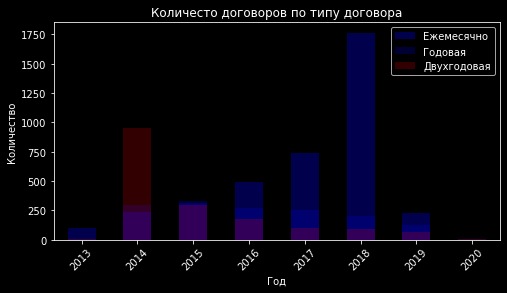

In [72]:
#построим графики 
df_type_month=(df
     .query('type=="month-to-month"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc='count')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Ежемесячно', alpha=0.3,rot=45, color='b')
)
df_type_one_year=(df
     .query('type=="one year"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc='count')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Годовая',color='b',alpha=0.2,rot=45, ax=df_type_month)
)

df_type_two_year=(df
     .query('type=="two year"')
     .pivot_table(index='begin_contract_year',values='total_charges', aggfunc='count')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Двухгодовая',color='r',alpha=0.2,rot=45, ax=df_type_one_year)
)
plt.title('Количесто договоров по типу договора')
plt.xlabel('Год')
plt.ylabel('Количество')




Вывод
- на графике видно как меняется количество заключенных договоров по типу договора по годам
- количество заключенных договоров по типу  'Ежемесячно' растет и достигает пика в 2019 году
- количество заключенных договоров по типу  'Годовая' уменьшается с каждым годом
- количество заключенных договоров по типу  'Двухгодовая' сильно уменьшается с каждым годом

Text(0, 0.5, 'Количество')

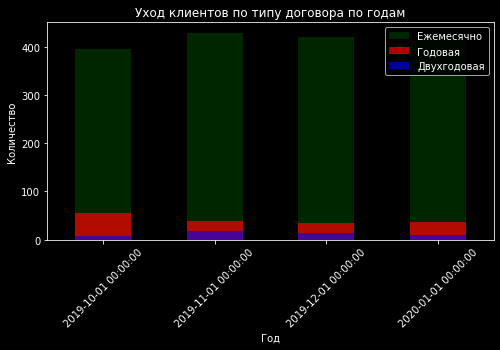

In [73]:
#построим графики 
df_type_month_end=(df
     .query('type=="month-to-month" and end_date!="2020-02-01"')
     .pivot_table(index='end_date',values='total_charges', aggfunc='count')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Ежемесячно', alpha=0.3,rot=45, color='g')
)
df_type_one_year_end=(df
     .query('type=="one year" and end_date!="2020-02-01"')
     .pivot_table(index='end_date',values='total_charges', aggfunc='count')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Годовая',color='r',alpha=0.7,rot=45, ax=df_type_month_end)
)

df_type_two_year_end=(df
     .query('type=="two year" and end_date!="2020-02-01"')
     .pivot_table(index='end_date',values='total_charges', aggfunc='count')
     .plot(y='total_charges',figsize=(8,4),kind='bar',label='Двухгодовая',color='b',alpha=0.6,rot=45, ax=df_type_one_year_end)
)
plt.title('Уход клиентов по типу договора по годам')
plt.xlabel('Год')
plt.ylabel('Количество')


In [74]:
#создадим сводние таблицы
df_type_month_end=(df
     .query('type=="month-to-month" and end_date!="2020-02-01"')
     .pivot_table(index='end_date',values='total_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)
df_type_one_year_end=(df
     .query('type=="one year" and end_date!="2020-02-01"')
     .pivot_table(index='end_date',values='total_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)

df_type_two_year_end=(df
     .query('type=="two year" and end_date!="2020-02-01"')
     .pivot_table(index='end_date',values='total_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)

In [75]:
df_type_month_end.columns = ['sum','count','median','mean','var','std','max','min']
df_type_month_end

sum  count  median         mean           var          std  \
end_date                                                                       
2019-10-01  465708.85    394  620.70  1182.002157  2.092376e+06  1446.504757   
2019-11-01  462648.20    429  474.80  1078.434033  1.837037e+06  1355.373340   
2019-12-01  524245.20    419  470.95  1251.181862  2.538712e+06  1593.333674   
2020-01-01  474580.00    413  503.60  1149.104116  2.317251e+06  1522.251908   

                max    min  
end_date                    
2019-10-01  6886.25  19.55  
2019-11-01  7133.25  19.25  
2019-12-01  7446.90  18.85  
2020-01-01  7548.10  19.10

In [76]:
df_type_one_year_end.columns = ['sum','count','median','mean','var','std','max','min']
df_type_one_year_end

sum  count    median         mean           var  \
end_date                                                            
2019-10-01  223570.25     56  3833.750  3992.325893  4.422570e+06   
2019-11-01  152184.45     39  4350.100  3902.165385  4.836528e+06   
2019-12-01  143873.25     34  4678.875  4231.566176  5.628643e+06   
2020-01-01  155363.25     37  4134.850  4199.006757  5.691853e+06   

                    std      max    min  
end_date                                 
2019-10-01  2102.990678  8684.80  145.0  
2019-11-01  2199.210853  8127.60   28.3  
2019-12-01  2372.476060  7674.55  331.3  
2020-01-01  2385.760517  8109.80   35.9

In [77]:
df_type_two_year_end.columns = ['sum','count','median','mean','var','std','max','min']
df_type_two_year_end

sum  count    median         mean           var          std  \
end_date                                                                        
2019-10-01  52428.10      8  6986.200  6553.512500  1.804989e+06  1343.498903   
2019-11-01  83680.15     17  5464.650  4922.361765  5.463400e+06  2337.391703   
2019-12-01  70267.10     13  5293.200  5405.161538  4.372693e+06  2091.098464   
2020-01-01  54378.10     10  5989.775  5437.810000  4.445097e+06  2108.339859   

                max      min  
end_date                      
2019-10-01  7723.90  4481.00  
2019-11-01  7611.85   692.10  
2019-12-01  7752.30  1327.15  
2020-01-01  7856.00  1099.60

Вывод
- из сводной таблицы и графика видно, что c октября 2019 года по январь 2020 года по всем типам договоров ушли клиенты, но больше всего ушли по типу договора 'Ежемесячно'. 

Text(0, 0.5, 'Выручка')

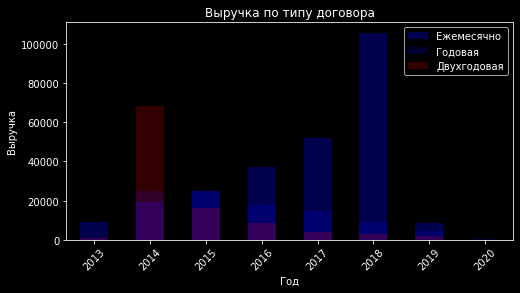

In [78]:
#построим графики 
df_type_month_monthlycharges=(df
     .query('type=="month-to-month"')
     .pivot_table(index='begin_contract_year',values='monthly_charges', aggfunc='sum')
     .plot(y='monthly_charges',figsize=(8,4),kind='bar',label='Ежемесячно', alpha=0.3,rot=45, color='b')
)
df_type_one_year_monthlycharges=(df
     .query('type=="one year"')
     .pivot_table(index='begin_contract_year',values='monthly_charges', aggfunc='sum')
     .plot(y='monthly_charges',figsize=(8,4),kind='bar',label='Годовая',color='b',alpha=0.2,rot=45, ax=df_type_month_monthlycharges)
)

df_type_two_year_monthlycharges=(df
     .query('type=="two year"')
     .pivot_table(index='begin_contract_year',values='monthly_charges', aggfunc='sum')
     .plot(y='monthly_charges',figsize=(8,4),kind='bar',label='Двухгодовая',color='r',alpha=0.2,rot=45, ax=df_type_one_year_monthlycharges)
)
plt.title('Выручка по типу договора')
plt.xlabel('Год')
plt.ylabel('Выручка')

In [79]:
#построим сводники
df_type_month_monthlycharges=(df
     .query('type=="month-to-month"')
     .pivot_table(index='begin_contract_year',values='monthly_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)
df_type_one_year_monthlycharges=(df
     .query('type=="one year"')
     .pivot_table(index='begin_contract_year',values='monthly_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)

df_type_two_year_monthlycharges=(df
     .query('type=="two year"')
     .pivot_table(index='begin_contract_year',values='monthly_charges', aggfunc=['sum','count','median','mean','var','std','max','min'])
)                  

In [80]:
df_type_month_monthlycharges.columns = ['sum','count','median','mean','var','std','max','min']
df_type_month_monthlycharges

sum  count  median       mean         var  \
begin_contract_year                                                    
2014                   9272.45    102  96.000  90.906373  357.806370   
2015                  19513.40    232  89.975  84.109483  443.703979   
2016                  24905.75    316  84.825  78.815665  568.773301   
2017                  37269.90    496  83.325  75.140927  610.155311   
2018                  51887.75    740  76.300  70.118581  653.776620   
2019                 105851.75   1765  69.050  59.972663  640.799438   
2020                   8593.15    224  27.450  38.362277  428.765846   

                           std     max    min  
begin_contract_year                            
2014                 18.915770  112.90  19.40  
2015                 21.064282  117.45  20.00  
2016                 23.848969  115.65  19.60  
2017                 24.701322  110.85  19.15  
2018                 25.569056  112.95  18.90  
2019                 25.314017  111.40  18.75  
2020                 20.706662   95.85  18.85

In [81]:
df_type_one_year_monthlycharges.columns = ['sum','count','median','mean','var','std','max','min']
df_type_one_year_monthlycharges

sum  count   median        mean         var  \
begin_contract_year                                                     
2013                   117.80      1  117.800  117.800000         NaN   
2014                 24777.90    292   94.375   84.855822  692.175722   
2015                 24744.50    327   81.150   75.671254  839.736702   
2016                 17613.95    267   69.550   65.969850  890.661691   
2017                 14794.40    250   61.225   59.177600  826.616504   
2018                  9072.30    203   43.750   44.691133  691.630812   
2019                  4477.20    125   20.550   35.817600  538.470333   
2020                   198.85      7   20.200   28.407143  411.342857   

                           std     max     min  
begin_contract_year                             
2013                       NaN  117.80  117.80  
2014                 26.309233  118.35   19.45  
2015                 28.978211  118.60   19.05  
2016                 29.843956  113.45   18.85  
2017                 28.750939  116.25   18.25  
2018                 26.298875  105.95   18.80  
2019                 23.204964  105.65   19.00  
2020                 20.281589   74.10   18.80

In [82]:
df_type_two_year_monthlycharges.columns = ['sum','count','median','mean','var','std','max','min']
df_type_two_year_monthlycharges

sum  count   median       mean          var  \
begin_contract_year                                                     
2013                   686.45      7  104.150  98.064286   272.029762   
2014                 68273.40    950   80.625  71.866737  1114.991474   
2015                 16177.65    293   59.500  55.213823  1046.987813   
2016                  8455.40    180   25.075  46.974444  1008.250237   
2017                  4052.90     99   24.750  40.938384   800.382848   
2018                  2925.55     87   24.100  33.627011   493.571675   
2019                  1957.80     67   20.400  29.220896   292.305239   
2020                    40.80      2   20.400  20.400000     0.005000   

                           std     max    min  
begin_contract_year                            
2013                 16.493325  114.20  65.30  
2014                 33.391488  118.75  19.10  
2015                 32.357191  116.05  18.40  
2016                 31.752956  115.05  19.10  
2017                 28.291038  116.15  18.55  
2018                 22.216473  108.90  18.70  
2019                 17.096937   88.95  19.05  
2020                  0.070711   20.45  20.35

Вывод\
из сводной таблицы и графика видно, что:
- по типу договора 'Ежемесячно' и количество договоров и выручка растет, а по другим типам договоров, наоборот контракты и выручка с каждым годом уменьшается, возможно клиенты перезаключают договор 'Ежемесячно'.

In [83]:
df_lifetime = df.pivot_table(index = 'lifetime', columns='churn',  values = 'customer_id', aggfunc = ['count'])#,'median','mean','var','std','max','min'])
df_lifetime

count             
churn    client_left still_client
lifetime                         
30             275.0        233.0
35             105.0          NaN
60              91.0          NaN
65              32.0        115.0
90              72.0          NaN
...              ...          ...
2125             5.0          NaN
2130             6.0        108.0
2155             1.0          NaN
2160             5.0        164.0
2190             6.0        356.0

[138 rows x 2 columns]

- многие клиенты уходят через месяц

<AxesSubplot:title={'center':'Уход клиента в зависимости от вида получения счета'}, xlabel='paperlessbilling'>

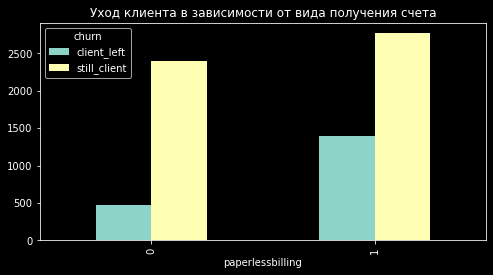

In [84]:
(
    df
    .pivot_table(index = 'paperlessbilling', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4),  title = 'Уход клиента в зависимости от вида получения счета', rot=90)
)

In [85]:
df.pivot_table(index = 'paperlessbilling', columns='churn',  values = 'customer_id', aggfunc = 'count')

churn             client_left  still_client
paperlessbilling                           
0                         469          2395
1                        1400          2768

- уходят клиенты больше всего получившие электронные счета

<AxesSubplot:title={'center':'Уход клиента в зависимости от способа оплаты'}, xlabel='payment_method'>

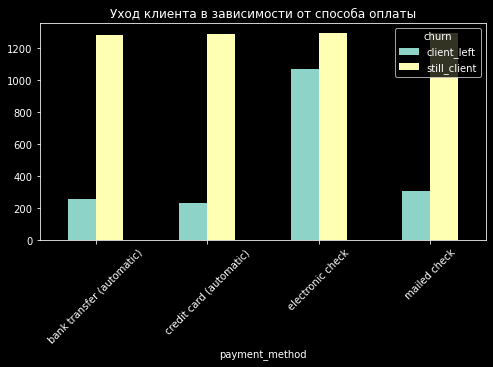

In [86]:
(
    df
    .pivot_table(index = 'payment_method', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента в зависимости от способа оплаты',rot=45)
)


In [87]:
df.pivot_table(index = 'payment_method', columns='churn',  values = 'customer_id', aggfunc = 'count')

churn                      client_left  still_client
payment_method                                      
bank transfer (automatic)          258          1284
credit card (automatic)            232          1289
electronic check                  1071          1294
mailed check                       308          1296

- уходят клиенты, у которых электронный способ оплаты

<AxesSubplot:title={'center':'Уход клиента в зависимости от пола'}, xlabel='gender'>

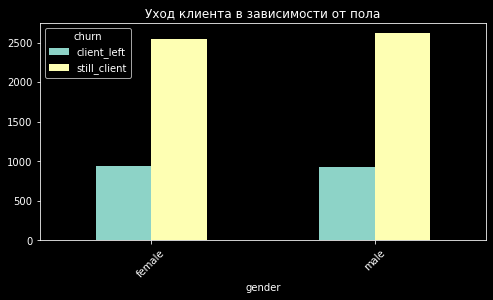

In [88]:
(
    df
    .pivot_table(index = 'gender', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4),  title = 'Уход клиента в зависимости от пола',rot=45)
)

In [89]:
df.pivot_table(index = 'gender', columns='churn',  values = 'customer_id', aggfunc = 'count')

churn   client_left  still_client
gender                           
female          939          2544
male            930          2619

- одинаково уходят и заключают договоры независимо от пола

<AxesSubplot:title={'center':'Уход клиента в зависимости от возраста'}, xlabel='Пожилые'>

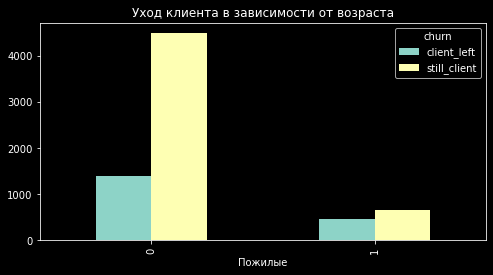

In [90]:
(
    df
    .pivot_table(index = 'seniorcitizen', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4),  xlabel='Пожилые', title = 'Уход клиента в зависимости от возраста', rot=90)
)

In [91]:
df.pivot_table(index = 'seniorcitizen', columns='churn',  values = 'customer_id', aggfunc = 'count')

churn          client_left  still_client
seniorcitizen                           
0                     1393          4497
1                      476           666

- пожилые клиенты больше всего уходят

<AxesSubplot:title={'center':'Уход клиента в зависимости от сервиса'}, xlabel='Сервис'>

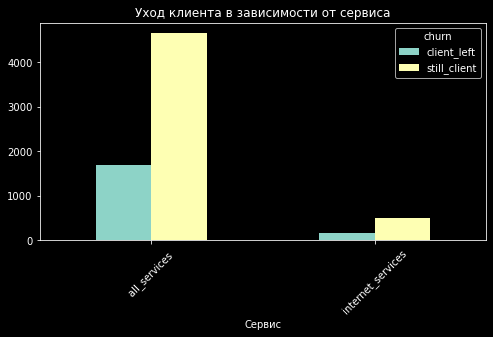

In [92]:
(
   df
    .pivot_table(index = 'services', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4),  xlabel='Сервис', title = 'Уход клиента в зависимости от сервиса',rot=45)
)

In [93]:
df.pivot_table(index = 'services', columns='churn',  values = 'customer_id', aggfunc = 'count')

churn              client_left  still_client
services                                    
all_services              1699          4653
internet_services          170           510

- уходят клиенты, которые пользуются и интернетом и звонками 

<AxesSubplot:title={'center':'Уход клиента в зависимости от наличия брака'}, xlabel='Наличия брака'>

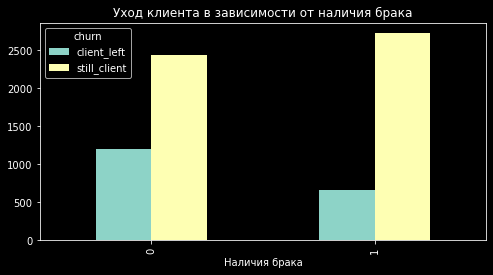

In [94]:
(
   df
    .pivot_table(index = 'partner', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), xlabel='Наличия брака', title = 'Уход клиента в зависимости от наличия брака', rot=90)
)

In [95]:
df.pivot_table(index = 'partner', columns='churn',  values = 'customer_id', aggfunc = 'count')

churn    client_left  still_client
partner                           
0               1200          2439
1                669          2724

- меньше всего уходят клиенты, которые состоят в браке  

<AxesSubplot:title={'center':'Уход клиента от наличия нескольких телефонных линий'}, xlabel='multiple_lines'>

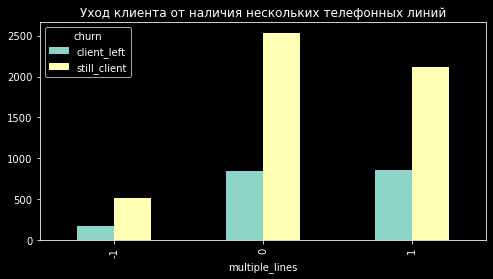

In [96]:
(
   df
    .pivot_table(index = 'multiple_lines', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента от наличия нескольких телефонных линий', rot=90)
)

In [97]:
df.pivot_table(index = 'multiple_lines', columns='churn',  values = 'customer_id', aggfunc = 'count')

churn           client_left  still_client
multiple_lines                           
-1                      170           510
 0                      849          2536
 1                      850          2117

- наличие нескольких телефонных линий не особо влияет на уход

<AxesSubplot:title={'center':'Уход клиента в зависимости от интернет-сервиса'}, xlabel='internet_service'>

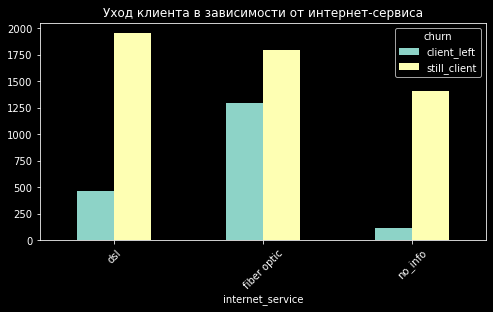

In [98]:
(
   df
    .pivot_table(index = 'internet_service', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента в зависимости от интернет-сервиса', rot=45)
)

In [99]:
df.pivot_table(index = 'internet_service', columns='churn',  values = 'customer_id', aggfunc = 'count')
    

churn             client_left  still_client
internet_service                           
dsl                       459          1957
fiber optic              1297          1799
no_info                   113          1407

- больше всего отказываются от сервиса fiber optic (оптоволоконный кабель)

<AxesSubplot:title={'center':'Уход клиента в зависимости от услуги "Блокировка небезопасных сайтов"'}, xlabel='online_security'>

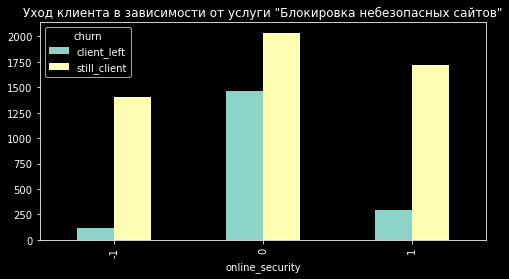

In [100]:
(
   df
    .pivot_table(index = 'online_security', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента в зависимости от услуги "Блокировка небезопасных сайтов"', rot=90)
)

In [101]:
df.pivot_table(index = 'online_security', columns='churn',  values = 'customer_id', aggfunc = 'count')
    

churn            client_left  still_client
online_security                           
-1                       113          1407
 0                      1461          2036
 1                       295          1720

- меньше всего уходят клиенты, у которых есть услуга "Блокировка небезопасных сайтов" (OnlineSecurity)

<AxesSubplot:title={'center':'Уход клиента в зависимости от услуг "Облачное хранилище файлов"'}, xlabel='online_backup'>

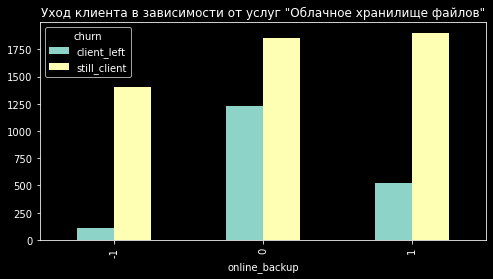

In [102]:
(
   df
    .pivot_table(index = 'online_backup', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента в зависимости от услуг "Облачное хранилище файлов"', rot=90)
)

In [103]:
df.pivot_table(index = 'online_backup', columns='churn',  values = 'customer_id', aggfunc = 'count')

churn          client_left  still_client
online_backup                           
-1                     113          1407
 0                    1233          1854
 1                     523          1902

- меньше клинетов отказываются от услуги "Облачное хранилище файлов"

<AxesSubplot:title={'center':'Уход клиента в зависимости от услуг "Антивирус"'}, xlabel='deviceprotection'>

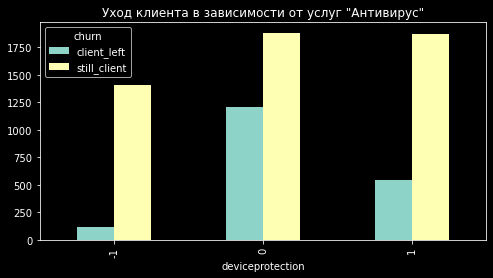

In [104]:
(
   df
    .pivot_table(index = 'deviceprotection', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента в зависимости от услуг "Антивирус"', rot=90)
)

In [105]:
df.pivot_table(index = 'deviceprotection', columns='churn',  values = 'customer_id', aggfunc = 'count')
 

churn             client_left  still_client
deviceprotection                           
-1                        113          1407
 0                       1211          1883
 1                        545          1873

- клиентам нравится услуга "Антивирус" (DeviceProtection). 

<AxesSubplot:title={'center':'Уход клиента в зависимости от услуги "Техподдержка"'}, xlabel='techsupport'>

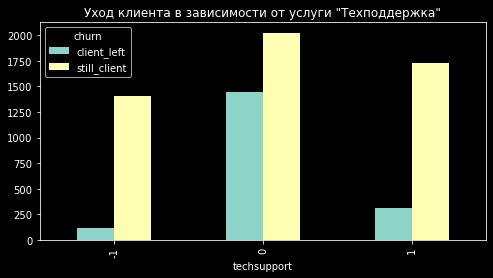

In [106]:
(
   df
    .pivot_table(index = 'techsupport', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента в зависимости от услуги "Техподдержка"')
)

In [107]:
df.pivot_table(index = 'techsupport', columns='churn',  values = 'customer_id', aggfunc = 'count')
 

churn        client_left  still_client
techsupport                           
-1                   113          1407
 0                  1446          2026
 1                   310          1730

- клиентам нравится услуга "Техподдержка" (TechSupport)


<AxesSubplot:title={'center':'Уход клиента в зависимости от услуги "Стриминговое телевидение"'}, xlabel='streaming_tv'>

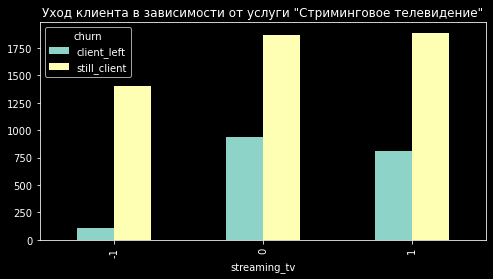

In [108]:
(
   df
    .pivot_table(index = 'streaming_tv', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента в зависимости от услуги "Стриминговое телевидение"', rot=90)
)

In [109]:
df.pivot_table(index = 'streaming_tv', columns='churn',  values = 'customer_id', aggfunc = 'count')
 

churn         client_left  still_client
streaming_tv                           
-1                    113          1407
 0                    942          1867
 1                    814          1889

- уход клиента не зависит от услуги "Стриминговое телевидение" (StreamingTV)

<AxesSubplot:title={'center':'Уход клиента в зависимости от услуги "Каталог фильмов"'}, xlabel='streaming_movies'>

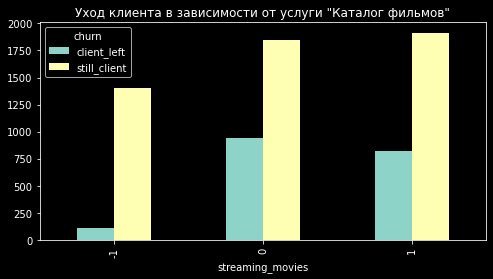

In [110]:
(
   df
    .pivot_table(index = 'streaming_movies', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(8, 4), title = 'Уход клиента в зависимости от услуги "Каталог фильмов"', rot=90)
)

In [111]:
df.pivot_table(index = 'streaming_movies', columns='churn',  values = 'customer_id', aggfunc = 'count')



churn             client_left  still_client
streaming_movies                           
-1                        113          1407
 0                        938          1843
 1                        818          1913

- уход клиента не зависит от услуги "Каталог фильмов" (StreamingMovies).

In [112]:
#целевой признак: поменяем тип данных 
df.loc[df['churn'] == 'client_left', 'churn'] = 1
df.loc[df['churn'] == 'still_client', 'churn'] = 0
df['churn'] = df['churn'].astype('int')

In [113]:
#дисбаланс классов
df['churn'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: churn, dtype: float64

In [114]:
# удаляем лишние столбцы(информация есть в столбце lifetime) 
df=df.drop([ 'begin_date', 'end_date', 'customer_id',
        'begin_contract_year', 'end_contract_year', 'begin_contract_month',
       'services'], axis=1)

In [115]:
df.head() 

type  paperlessbilling             payment_method  \
0  month-to-month                 1           electronic check   
1        one year                 0               mailed check   
2  month-to-month                 1               mailed check   
3        one year                 0  bank transfer (automatic)   
4  month-to-month                 1           electronic check   

   monthly_charges  total_charges  gender  seniorcitizen  partner  dependents  \
0            29.85          29.85  female              0        1           0   
1            56.95        1889.50    male              0        0           0   
2            53.85         108.15    male              0        0           0   
3            42.30        1840.75    male              0        0           0   
4            70.70         151.65  female              0        0           0   

   multiple_lines internet_service  online_security  online_backup  \
0              -1              dsl                0              1   
1               0              dsl                1              0   
2               0              dsl                1              1   
3              -1              dsl                1              0   
4               0      fiber optic                0              0   

   deviceprotection  techsupport  streaming_tv  streaming_movies  churn  \
0                 0            0             0                 0      0   
1                 1            0             0                 0      0   
2                 0            0             0                 0      1   
3                 1            1             0                 0      0   
4                 0            0             0                 0      1   

   lifetime  
0        30  
1      1035  
2        60  
3      1370  
4        60

interval columns not set, guessing: ['paperlessbilling', 'monthly_charges', 'total_charges', 'seniorcitizen', 'partner', 'dependents', 'multiple_lines', 'online_security', 'online_backup', 'deviceprotection', 'techsupport', 'streaming_tv', 'streaming_movies', 'churn', 'lifetime']


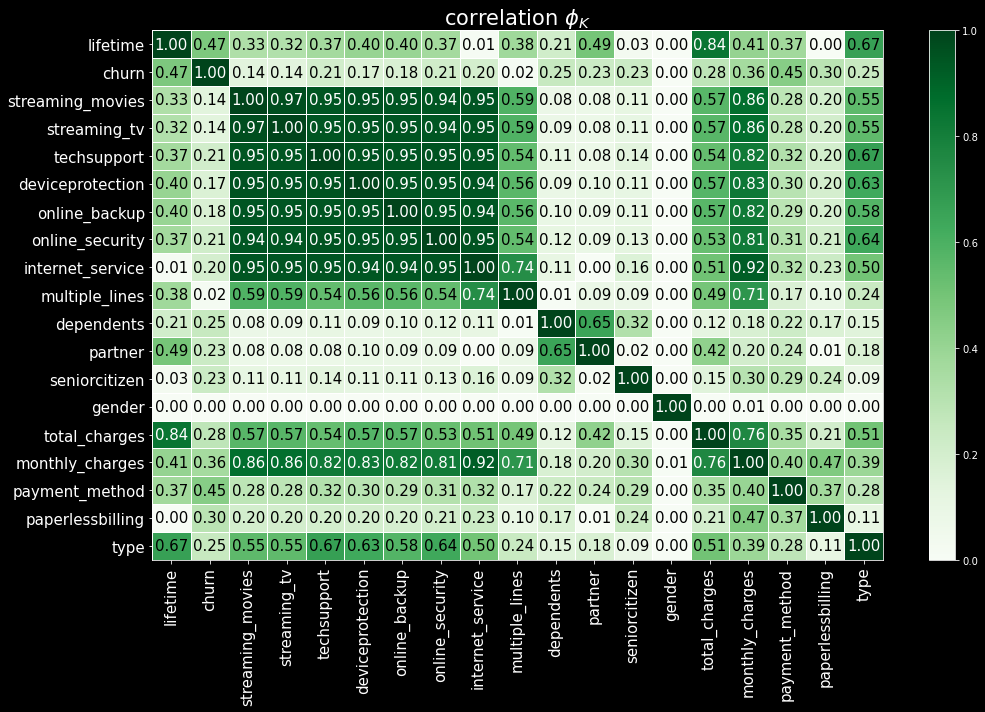

In [116]:
phik_overview = df.phik_matrix()
phik_overview['churn'].sort_values(ascending=False)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

Корреляция Фика между признаками (Нелинейная зависимость признаков в датасете) 

На отток клиенты больше всего влияют: 
- lifetime: длительность договора
- payment_method: способ оплаты 
- monthly_charges: 'Ежемесячная' оплата
- paperlessbilling: способ получения счета
- total_charges: общая сумма оплаты
- dependents: наличия иждевенца
- type: тип договора

- выручка зависит от подключенных услуг: корреляция Фика больше 0,82 
- сильная связь есть между 'monthly_charges'и 'total_charges': корреляция Фика 0.76
- интерсно заметить, что сильная связь есть между дополнительними  услугами: корреляция Фика больше 0.94, услуги подключаются вместе 
- тип договора коррелирует с подключенными услугами: корреляция Фика больше 0.50, возможно клиенту предлагают дополнительные услуги 
- наличия партнера зависит от признака наличия иждивенцов: корреляция Фика больше 0.65, возможно есть много домохозяек


Корреляция Пирсона между признаками (Линейная зависимость признаков в датасете)
- Корреляция Пирсона больше 0.82 между 'total_charges' и 'lifetime'
- сильная связь есть между 'monthly_charges'и 'total_charges', корреляция Пирсона 0.65

Построили графики и создали сводные таблицы и сделали выводы:
- больше всего уходят те клиенты, у которых тип оплаты по договору: 'Ежемесячно',
второе местоe у тех, у кого тип оплаты 'Годовой',
а меньше всего уходят клиенты, у которых тип оплаты по договору 'Двухгодовой' 
- выручка снижается по всем типам договора оплаты за все время.
- количество заключенных договоров по типу  'Ежемесячно' растет и достигает пика в 2019 году, а 2020 год не полный. Несмотря на рост заключенных договоров, выручка уменьшается.
- количество заключенных договоров по типу 'Годовая' уменьшается с каждым годом. 
- из таблицы можно сделать вывод, что количество заключенных договоров по типу 'Двухгодовая' сильно уменьшается с каждым годом. 
- количество заключенных договоров по типу  'Ежемесячно' растет и достигает пика в 2019 году
- количество заключенных договоров по типу  'Годовая' уменьшается с каждым годом
- количество заключенных договоров по типу  'Двухгодовая' сильно уменьшается с каждым годом
- из сводной таблицы и графика видно, что c октября 2019 года по январь 2020 года по всем типам договоров ушли клиенты, но больше всего ушли по типу договора 'Ежемесячно'. 
- из сводной таблицы и графика видно, что c октября 2019 года по январь 2020 года по всем типам договоров ушли клиенты, но больше всего ушли по типу договора 'Ежемесячно'. 
- по типу договора 'Ежемесячно' и количество договоров и выручка растет, а по другим типам договоров, наоборот контракты и выручка с каждым годом уменьшается, возможно клиенты перезаключают договор 'Ежемесячно'.
- многие клиенты уходят через месяц
- уходят клиенты больше всего получившие электронные счета
- электронный способ оплаты это характерная черта уходящего клиента 
- одинаково уходят и заключают договоры независимо от пола
- пожилые клиенты больше всего уходят
- уходят клиенты, которые пользуются и интернетом и звонками 
- меньше всего уходят клиенты, которые состоят в браке  
- наличие нескольких телефонных линий не особо влияет на уход
- больше всего отказываются от сервиса fiber optic (оптоволоконный кабель)
- меньше всего уходят клиенты, у которых есть услуга "Блокировка небезопасных сайтов" (OnlineSecurity)
- меньше клинетов отказываются от услуги "Облачное хранилище файлов"
- клиентам нравится услуги "Техподдержка" (TechSupport) и "Антивирус" (DeviceProtection)
- уход клиента не зависит от услуги "Стриминговое телевидение" (StreamingTV)
- уход клиента не зависит от услуги "Каталог фильмов" (StreamingMovies).

# 4. Машинное обучение

#  Модель CatBoostClassifier

In [117]:
#разбиваем сначала на 2 части обучающую и валидационную (60%),тестовую (40)
train, test = train_test_split(df, train_size=0.60, random_state=42, stratify = df['churn'])   
#разбиваем  обучающую на 2 части: тестовую(50%),валидационную (50)
val, test = train_test_split(test, train_size=0.5, random_state=42,  stratify = test['churn'])


In [118]:
test['churn'].mean()

0.2658137882018479

In [119]:
val['churn'].mean()

0.26600284495021337

In [120]:
print('Размер обучающей выборки',train.shape)
print('Размер тестовой выборки',test.shape)
print('Размер валидационной выборки',val.shape)

Размер обучающей выборки (4219, 19)
Размер тестовой выборки (1407, 19)
Размер валидационной выборки (1406, 19)


In [121]:
# список призноков
X = ['monthly_charges','type', 'paperlessbilling', 'payment_method', 'lifetime',
       'total_charges', 'seniorcitizen', 'partner', 'streaming_movies', 'internet_service',
       'multiple_lines',  'online_security', 'streaming_tv', 'dependents',
       'online_backup', 'deviceprotection', 'techsupport',  
       'gender']
# список целевого признака
y=['churn']

#список категориальных признаков
cat_features =['type','payment_method', 
             'internet_service','gender'] 


In [122]:

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [123]:
params={'verbose':50,
       'random_seed':42,
       'learning_rate':0.4,
        'iterations':1000,
        'eval_metric' : 'AUC',
        'loss_function': 'Logloss',
        'depth' :2
       }

In [124]:
model =CatBoostClassifier(**params) 

In [125]:
model.fit(train_data, eval_set=valid_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7255472	best: 0.7255472 (0)	total: 63.6ms	remaining: 1m 3s
50:	test: 0.8693985	best: 0.8700281 (48)	total: 173ms	remaining: 3.22s
100:	test: 0.8789964	best: 0.8790768 (87)	total: 285ms	remaining: 2.54s
150:	test: 0.8850436	best: 0.8852249 (149)	total: 392ms	remaining: 2.2s
200:	test: 0.8892382	best: 0.8894559 (194)	total: 501ms	remaining: 1.99s
250:	test: 0.8963735	best: 0.8965083 (249)	total: 607ms	remaining: 1.81s
300:	test: 0.8964254	best: 0.8979099 (275)	total: 717ms	remaining: 1.66s
350:	test: 0.8953294	best: 0.8979099 (275)	total: 818ms	remaining: 1.51s
400:	test: 0.8968399	best: 0.8979099 (275)	total: 917ms	remaining: 1.37s
450:	test: 0.8976405	best: 0.8979099 (275)	total: 1.03s	remaining: 1.26s
500:	test: 0.9033663	best: 0.9035503 (499)	total: 1.14s	remaining: 1.14s
550:	test: 0.9018455	best: 0.9037705 (503)	total: 1.24s	remaining: 1.01s
600:	test: 0.9069936	best: 0.9072579 (596)	total: 1.38s	remaining: 916ms
650:	test: 0.9073330	best: 0.9077398 (633)	total: 1.48s	re

# Тестирование модели

In [126]:
roc_auc_cat = roc_auc_score(test[y], model.predict_proba(test[X])[:, 1])
print(f"Accuracy на тестовой выборке : {(model.score(test[X], test[y])):.2f}")
print(f"ROC_AUC для модели CatBoost на тестовой выборке: {roc_auc_cat:.3f}")

Accuracy на тестовой выборке : 0.88
ROC_AUC для модели CatBoost на тестовой выборке: 0.922


Модель | ROC_AUC на валидационной выборке | ROC_AUC на тестовой выборке | Accuracy на тестовой выборке
--- | --- | --- | ---
*CatBoostClassifier* | **0.907** | **0.922** | **0.88**



- С помощью Shap можно определить наиболее значимые факторы

In [127]:
#проверим на адекватность модели
#рассчитываем важность признаков с помощью SHAP
model.get_feature_importance(prettified=True)


Feature Id  Importances
0           lifetime    63.066153
1      total_charges     8.981895
2    monthly_charges     7.818584
3   deviceprotection     5.562094
4               type     5.475288
5     payment_method     1.942618
6   internet_service     1.927529
7      seniorcitizen     0.945436
8   paperlessbilling     0.850488
9        techsupport     0.637029
10   online_security     0.556631
11    multiple_lines     0.457044
12  streaming_movies     0.414490
13      streaming_tv     0.400436
14            gender     0.309376
15     online_backup     0.265134
16        dependents     0.218986
17           partner     0.170789

Вывод\
Из таблицы видно, ответственность объекта за изменение выходных данных модели, такие как 
- lifetime 
- total_charges
- monthly_charges
- type ,payment_method
- internet_service


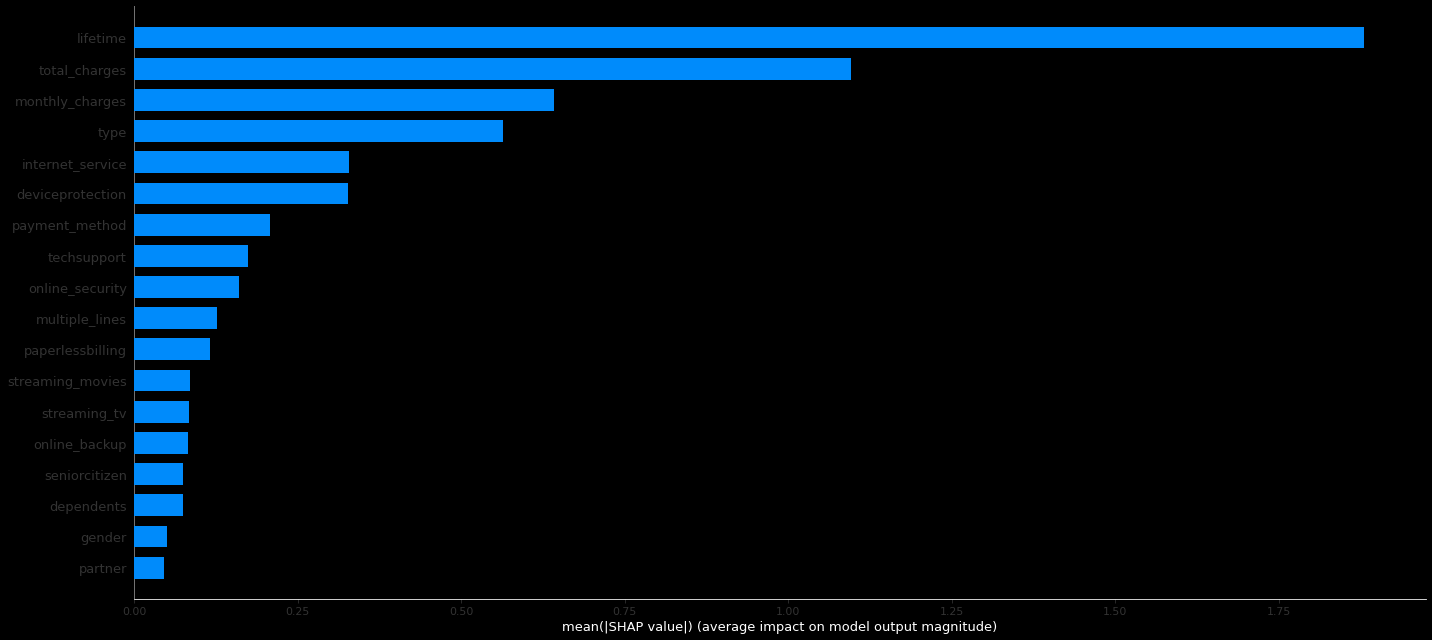

In [128]:
# построим барчарт
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X], plot_type="bar", plot_size=(20,9))

- Чтобы понять, как отдельный объект влияет на выходные данные модели, мы можем построить график зависимости значения этого объекта от значение функции для всех примеров в наборе данных. Поскольку значения SHAP представляют ответственность объекта за изменение выходных данных модели, график ниже представляет изменение оттока клиента 

In [129]:
# Рассмотрим SHAP-графики. Построим такой график для каждого наблюдения в датасете

shap.force_plot(explainer.expected_value, shap_values, test[X])

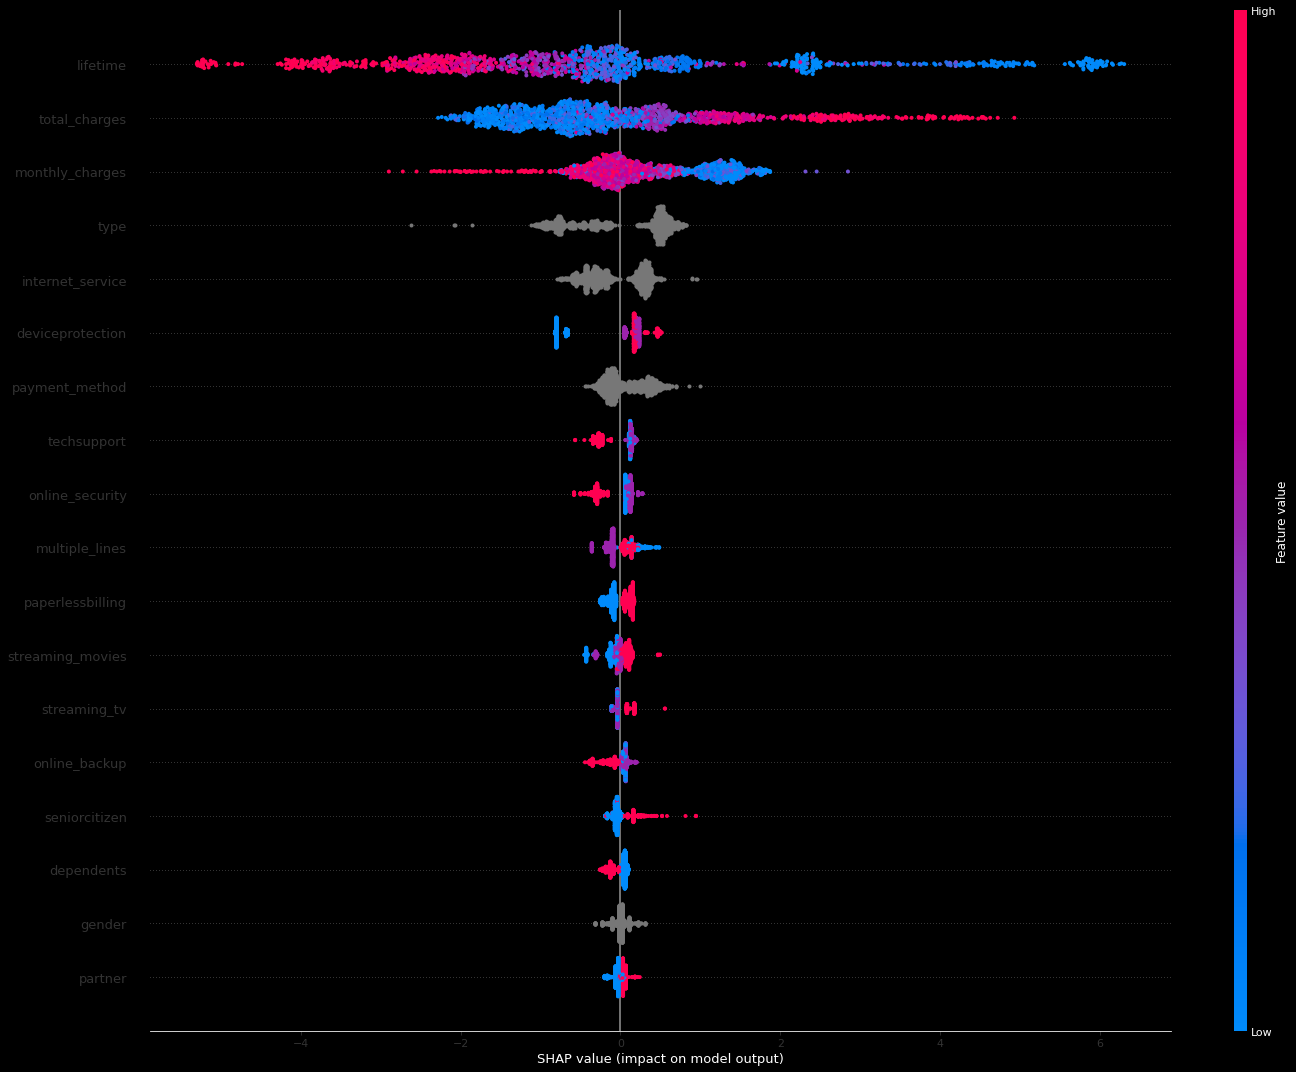

In [130]:
# сортируем объекты по сумме значений SHAP на тестовой выборке 
shap.summary_plot(shap_values, test[X], plot_size=(20,15))

- Приведенный выше график сортирует объекты по сумме значений SHAP на тестовой выборке и использует значения SHAP для отображения распределения влияния каждого объекта на выходные данные модели.

In [131]:
xplainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])

# Можно объяснить предсказание для конкретного  клиента
shap.force_plot(explainer.expected_value, shap_values[0,:], test[X].iloc[0,:])

In [132]:
#посмотреть зависимость предсказаний от конкретного признака в виде 2D графика
features = model.get_feature_importance(prettified=True)['Feature Id'].values

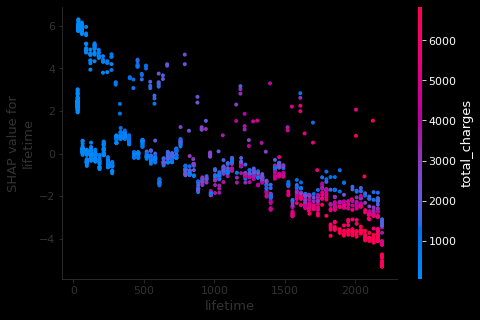

In [133]:
shap.dependence_plot('lifetime', shap_values, test[X])

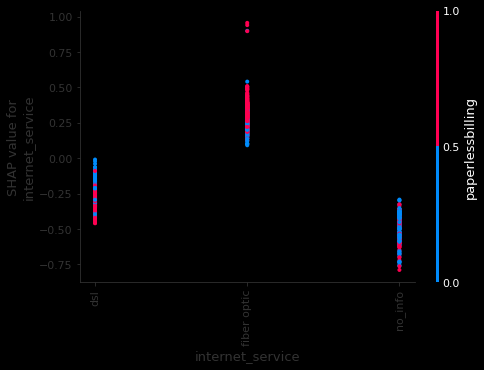

In [134]:
shap.dependence_plot('internet_service', shap_values, test[X])

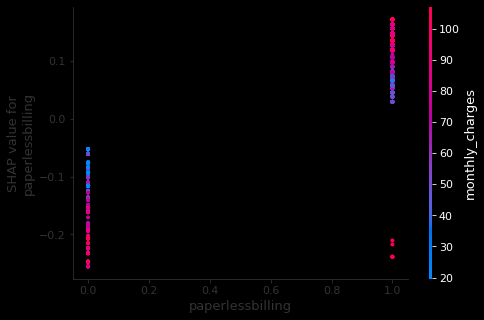

In [135]:
shap.dependence_plot('paperlessbilling', shap_values, test[X])

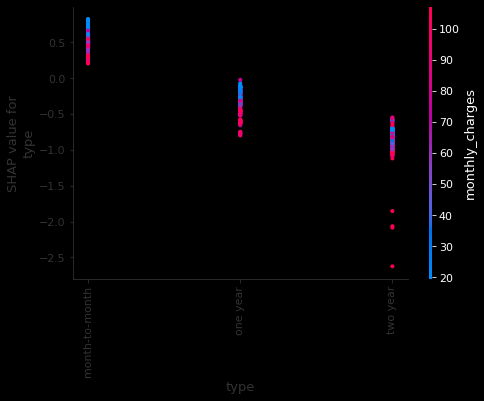

In [136]:
shap.dependence_plot('type', shap_values, test[X])

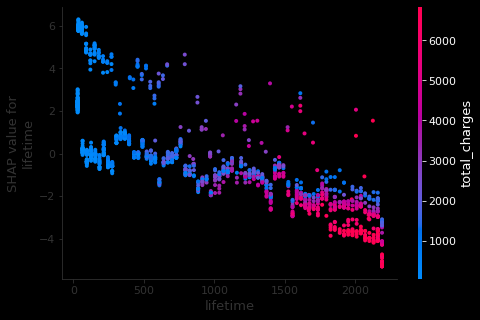

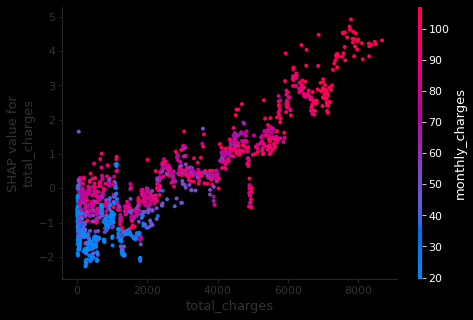

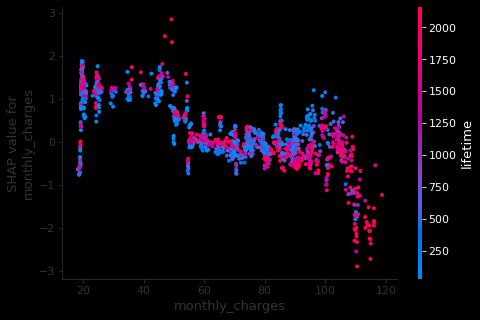

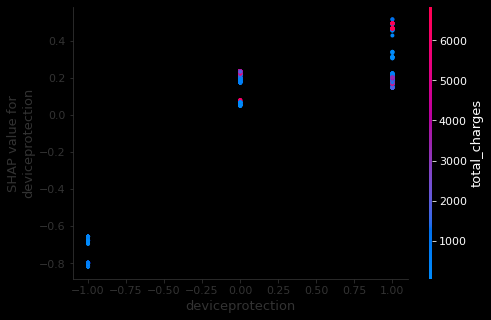

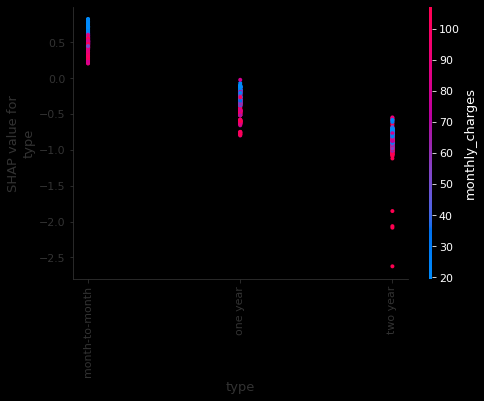

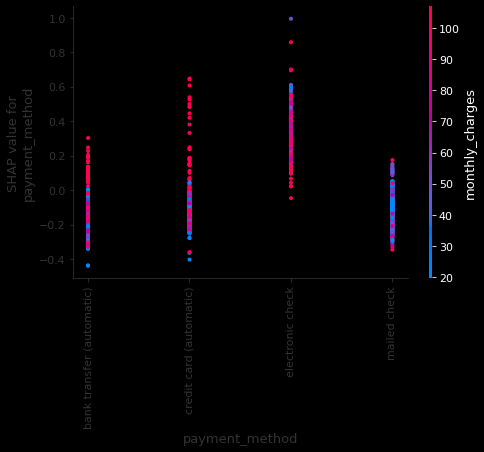

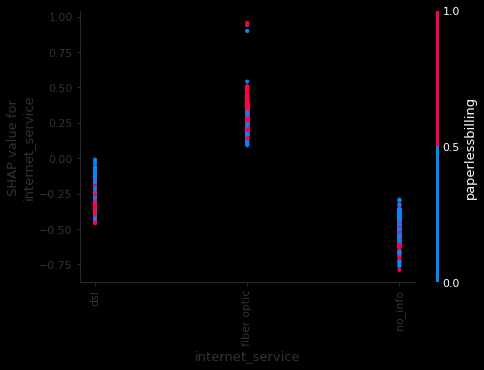

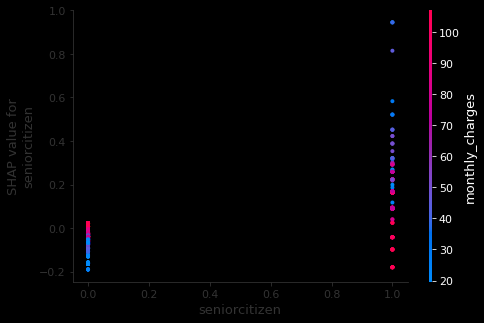

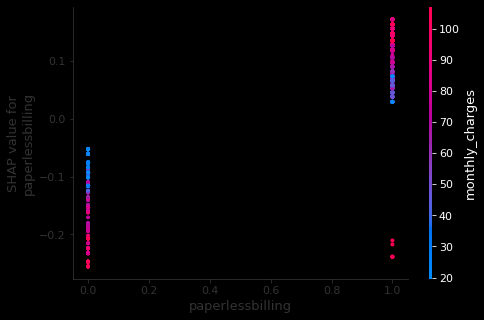

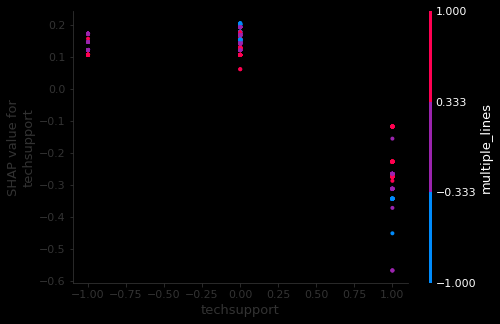

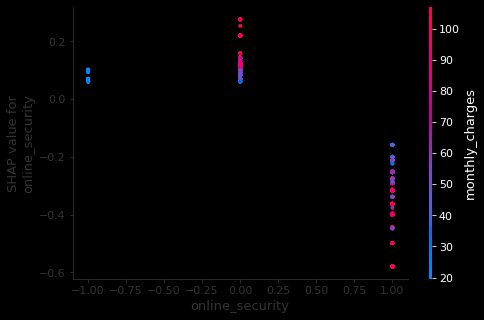

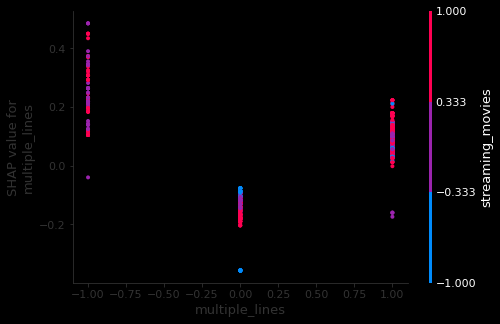

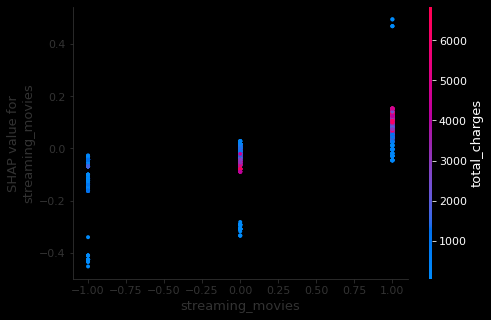

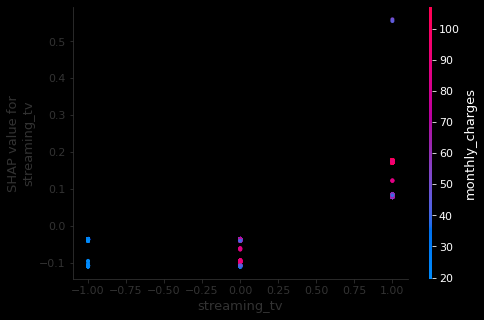

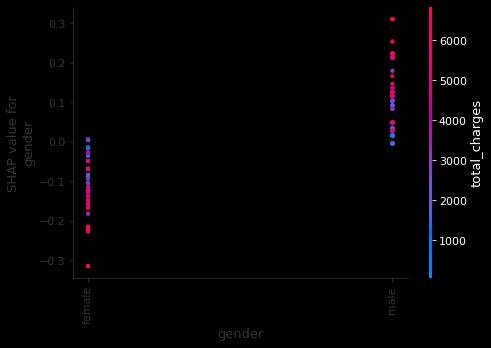

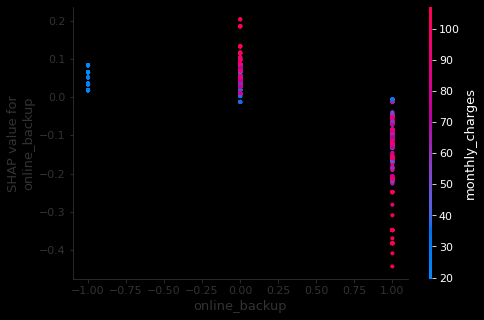

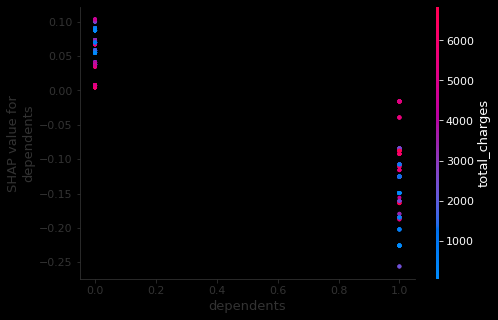

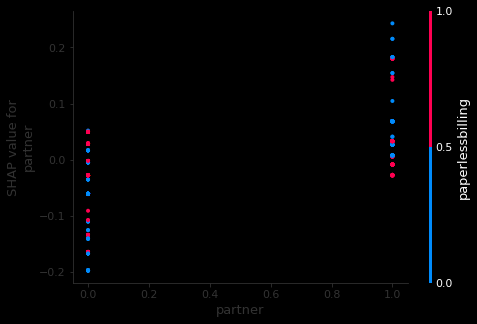

In [137]:
# посмотреть зависимость предсказаний от конкретного признака в виде 2D графика для всех признаков
for features in features:
    shap.dependence_plot(features, shap_values, test[X])

Вывод

Полученные графики интерпретируется следующим образом
- чем больше длительность договора, тем меньше вероятность его ухода
- чем  больше оплата за услуги, тем выше вероятность оттока 
- электронный способ оплаты это характерная черта уходящего клиента 
- клиенты с типом договора 'Ежемесячно' с большой вероятностью уйдут
- дополнительные подключенные услуги, такие как онлайн-телевидение и онлайн-кинотеатры, а также вид подключения  оптоволокно повышают вероятнось оттока клиента
- клиенты с возрастом больше 60 лет с большой вероятностью уходят
- клиенты без партнера с большой вероятностю уходят
 
Таким образом, из этого графика можно сделать интересные выводы и проверить их адекватность\
На основании подобных выводов можно сформировать портрет клиента:
- он до 60 лет, 
- женат(замужем)
- есть иждевенец
- давно пользуется услугами
- низкая общая оплата за услуги, дополнительных подключенных услуг меньше
- наличие дополнительны услуг блокировки небезопасных сайтов, облачного хранилища, антивируса
- чаше всего у клиента тип подключения интернета DSL  


#  Модел LGBMClassifier

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7032 non-null   object 
 1   paperlessbilling  7032 non-null   int64  
 2   payment_method    7032 non-null   object 
 3   monthly_charges   7032 non-null   float64
 4   total_charges     7032 non-null   float64
 5   gender            7032 non-null   object 
 6   seniorcitizen     7032 non-null   int64  
 7   partner           7032 non-null   int64  
 8   dependents        7032 non-null   int64  
 9   multiple_lines    7032 non-null   int8   
 10  internet_service  7032 non-null   object 
 11  online_security   7032 non-null   int8   
 12  online_backup     7032 non-null   int8   
 13  deviceprotection  7032 non-null   int8   
 14  techsupport       7032 non-null   int8   
 15  streaming_tv      7032 non-null   int8   
 16  streaming_movies  7032 non-null   int8   


In [139]:
df.columns

Index(['type', 'paperlessbilling', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'deviceprotection', 'techsupport', 'streaming_tv',
       'streaming_movies', 'churn', 'lifetime'],
      dtype='object')

In [140]:
# поменяем тип данных категориальных признаков
for col in ['type', 'paperlessbilling', 'payment_method', 
      'gender', 'seniorcitizen', 'partner', 'dependents',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'deviceprotection', 'techsupport', 'streaming_tv',
       'streaming_movies']:
    df[col] = df[col].astype('category')             

In [141]:
#разбиваем сначала на 2 части обучающую и валидационную (80%),тестовую (20)
train, test = train_test_split(df, train_size=0.60, random_state=42, stratify = df['churn'])
    
#разбиваем  обучающую на 2 части: обучающую (60%),валидационную (20)
val, test = train_test_split(test, train_size=0.5, random_state=42,  stratify = test['churn'])
print('Размер обучающей выборки',train.shape)
print('Размер тестовой выборки',test.shape)
print('Размер валидационной выборки',val.shape)

Размер обучающей выборки (4219, 19)
Размер тестовой выборки (1407, 19)
Размер валидационной выборки (1406, 19)


In [142]:
cat_features =['type', 'paperlessbilling', 'payment_method', 
      'gender', 'seniorcitizen', 'partner', 'dependents',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'deviceprotection', 'techsupport', 'streaming_tv',
       'streaming_movies']


In [143]:

X = ['monthly_charges','type', 'paperlessbilling', 'payment_method', 'lifetime',
       'total_charges', 'seniorcitizen', 'partner', 'streaming_movies', 'internet_service',
       'multiple_lines',  'online_security', 'streaming_tv', 'dependents',
       'online_backup', 'deviceprotection', 'techsupport',  
       'gender']
y=['churn']

In [144]:
model_lgb = lgb.LGBMClassifier(categorical_feature=cat_features, learning_rate=0.2, max_depth=2, 
                               n_estimators=50, min_child_samples =1, class_weight='balanced',
                               reg_alpha = 0,  objective='binary', metric = 'auc', random_state=42, 
                               num_iteration=700, verbose=-1)


In [145]:

model_lgb.fit(train[X], train[y], eval_set=(val[X],val[y]))

[LightGBM] [Warning] num_iterations is set=700, num_iteration=700 will be ignored. Current value: num_iterations=700
[1]	valid_0's auc: 0.78434
[2]	valid_0's auc: 0.804431
[3]	valid_0's auc: 0.817576
[4]	valid_0's auc: 0.818048
[5]	valid_0's auc: 0.818105
[6]	valid_0's auc: 0.820055
[7]	valid_0's auc: 0.827067
[8]	valid_0's auc: 0.829163
[9]	valid_0's auc: 0.828519
[10]	valid_0's auc: 0.829433
[11]	valid_0's auc: 0.831075
[12]	valid_0's auc: 0.833677
[13]	valid_0's auc: 0.834485
[14]	valid_0's auc: 0.838193
[15]	valid_0's auc: 0.838154
[16]	valid_0's auc: 0.838991
[17]	valid_0's auc: 0.838581
[18]	valid_0's auc: 0.83898
[19]	valid_0's auc: 0.841202
[20]	valid_0's auc: 0.841482
[21]	valid_0's auc: 0.841704
[22]	valid_0's auc: 0.841975
[23]	valid_0's auc: 0.842874
[24]	valid_0's auc: 0.843218
[25]	valid_0's auc: 0.843541
[26]	valid_0's auc: 0.843311
[27]	valid_0's auc: 0.843636
[28]	valid_0's auc: 0.845242
[29]	valid_0's auc: 0.845175
[30]	valid_0's auc: 0.846731
[31]	valid_0's auc: 0.84

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Found `num_iteration` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
categorical_feature in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[147]	valid_0's auc: 0.86215
[148]	valid_0's auc: 0.862083
[149]	valid_0's auc: 0.861873
[150]	valid_0's auc: 0.861878
[151]	valid_0's auc: 0.862477
[152]	valid_0's auc: 0.862397
[153]	valid_0's auc: 0.862368
[154]	valid_0's auc: 0.862288
[155]	valid_0's auc: 0.862511
[156]	valid_0's auc: 0.862638
[157]	valid_0's auc: 0.862705
[158]	valid_0's auc: 0.862346
[159]	valid_0's auc: 0.862188
[160]	valid_0's auc: 0.862122
[161]	valid_0's auc: 0.862075
[162]	valid_0's auc: 0.86228
[163]	valid_0's auc: 0.861956
[164]	valid_0's auc: 0.862207
[165]	valid_0's auc: 0.862096
[166]	valid_0's auc: 0.862031
[167]	valid_0's auc: 0.862529
[168]	valid_0's auc: 0.862653
[169]	valid_0's auc: 0.862715
[170]	valid_0's auc: 0.862972
[171]	valid_0's auc: 0.862951
[172]	valid_0's auc: 0.862904
[173]	valid_0's auc: 0.863652
[174]	valid_0's auc: 0.864232
[175]	valid_0's auc: 0.864235
[176]	valid_0's auc: 0.864123
[177]	valid_0's auc: 0.863813
[178]	valid_0's auc: 0.863844
[179]	valid_0's auc: 0.863859
[180]	valid_

[588]	valid_0's auc: 0.888828
[589]	valid_0's auc: 0.888838
[590]	valid_0's auc: 0.889006
[591]	valid_0's auc: 0.889162
[592]	valid_0's auc: 0.889525
[593]	valid_0's auc: 0.889641
[594]	valid_0's auc: 0.889628
[595]	valid_0's auc: 0.889916
[596]	valid_0's auc: 0.889939
[597]	valid_0's auc: 0.889856
[598]	valid_0's auc: 0.889887
[599]	valid_0's auc: 0.889833
[600]	valid_0's auc: 0.889791
[601]	valid_0's auc: 0.889771
[602]	valid_0's auc: 0.88974
[603]	valid_0's auc: 0.889737
[604]	valid_0's auc: 0.889734
[605]	valid_0's auc: 0.889955
[606]	valid_0's auc: 0.890048
[607]	valid_0's auc: 0.889841
[608]	valid_0's auc: 0.889947
[609]	valid_0's auc: 0.889996
[610]	valid_0's auc: 0.889926
[611]	valid_0's auc: 0.889996
[612]	valid_0's auc: 0.889934
[613]	valid_0's auc: 0.889768
[614]	valid_0's auc: 0.889812
[615]	valid_0's auc: 0.890232
[616]	valid_0's auc: 0.890237
[617]	valid_0's auc: 0.890221
[618]	valid_0's auc: 0.890203
[619]	valid_0's auc: 0.890196
[620]	valid_0's auc: 0.890216
[621]	valid

LGBMClassifier(categorical_feature=['type', 'paperlessbilling',
                                    'payment_method', 'gender', 'seniorcitizen',
                                    'partner', 'dependents', 'multiple_lines',
                                    'internet_service', 'online_security',
                                    'online_backup', 'deviceprotection',
                                    'techsupport', 'streaming_tv',
                                    'streaming_movies'],
               class_weight='balanced', learning_rate=0.2, max_depth=2,
               metric='auc', min_child_samples=1, n_estimators=50,
               num_iteration=700, objective='binary', random_state=42,
               reg_alpha=0, verbose=-1)

# Тестирование модели

In [146]:
roc_auc_lgb= roc_auc_score(test[y], model_lgb.predict_proba(test[X])[:, 1])

In [147]:
print(f"Accuracy на тестовой выборке : {(model_lgb.score(test[X], test[y])):.2f}")
print(f"ROC_AUC для модели LGBMClassifier на тестовой выборке: {roc_auc_lgb:.3f}")

Accuracy на тестовой выборке : 0.83
ROC_AUC для модели LGBMClassifier на тестовой выборке: 0.906


Вывод\

Модель | ROC_AUC на валидационной выборке | ROC_AUC на тестовой выборке | Accuracy на тестовой выборке
--- | --- | --- | ---
*LGBMClassifier* | **0.890** | **0.906** | **0.83**




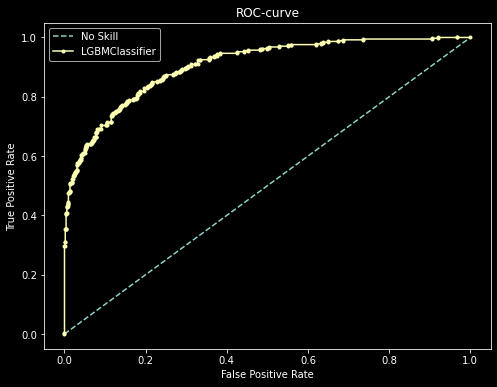

In [148]:
# построим ROC-кривую 
fig = plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(test[y], model_lgb.predict_proba(test[X])[:, 1])
plt.plot(fpr, tpr, marker='.', label='LGBMClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.show()

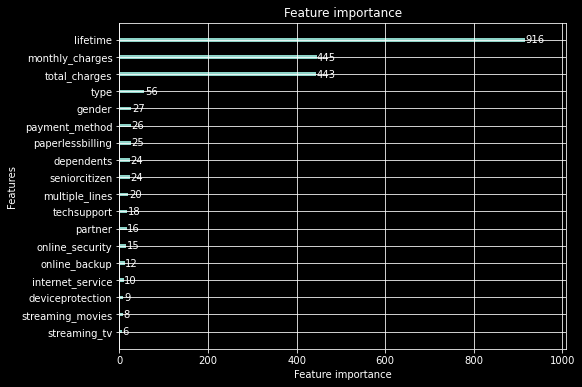

In [149]:
lgb.plot_importance(model_lgb, figsize=(8,6));

In [150]:
#model_lgb.feature_importances_

Вывод\
Построим таблицу по метрикам


Модель | ROC_AUC на валидационной выборке | ROC_AUC на тестовой выборке | Accuracy на тестовой выборке
--- | --- | --- | ---
*CatBoostClassifier* | **0.907** | **0.922** | **0.88**
*LGBMClassifier* | **0.890** | **0.906** | **0.83**

Из таблицы видно,что метрики ROC_AUC и  Accuracy больше у модели "CatBoostClassifier"

# ОТЧЕТ ПО РЕШЕНИЮ


# №1. Загрузка данных
Общие выводы
1. Датасет phone
- customerID -уникальный идентификатор клиента
- MultipleLines - наличие нескольких телефонных линий у клиента

- датасет phone содержит 2 столбца и 6361 строк
- пропущенных значений нет
- у 2971 клиента есть нескольких телефонных линий 

2. Датасет contract
- датасет contract содержит 8 столбцов и 7043 строк
- пропущенных значений нет
- по слобцу 'MonthlyCharges'  среднее:64.76, медиана:70.35
- тип данных в столбцах  'BeginDate', 'EndDate' нужно менять datetime64, а в столбце 'TotalCharges' на float64
- с сентября 2019 года 17% клинетов подключили услугу, возможно была акция
- с октября 2019 года расторгнули 27% клиентов 
- у 55% клиентов договор ежемесячно, а годовые или двухгодовые договоры почти одинаково заключают
- 59% клиентов предпочитают получить электронный счет
- клиенты наличними не платят

- customerID - уникальный идентификатор клиента
- BeginDate - дата начала подключения к оператору
- EndDate - дата окончания договора
- Type - тип оплаты по договору: ежемесячно, годовой или двухгодовой
- PaperlessBilling - электронный счет
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячный платёж тарифа
- TotalCharges -  итоговая сумма за все время
3. Датасет personal

- датасет personal содержит 5 столбцов и 7043 строк
- пропущенных значений нет
- в датасете мужчины и женщины в одинаковом количестве 
- 16% старше 60 лет
- почти половина состоит в браке
- у 30% клиентов есть иждивенцы

- customerID - уникальный идентификатор клиента
- gender - пол клиента 
- SeniorCitizen - клиент пожилой или нет (старше 60 лет https://www.consultant.ru/law/podborki/vozrast_pozhilogo_cheloveka/?ysclid=l4wjdb3xz6720426625)
- Partner - клиент в браке или нет
- Dependents - наличие иждивенцев
4. Датасет internet
- датасет personal содержит 8 столбцов и 5517 строк
- пропущенных значений нет
- 3096 клиентов предпочитают тип подключения интернета оптоволокно 
- у 2019 есть услуга блокировки небезопасных сайтов
- у 2429 есть услуга облачного хранилища для создания резервных копий
- у 2422 есть услуга антивируса
- у 2044 есть услуга технической поддержки
- у 2707 есть услуги онлайн-телевидения
- у 2732 есть услуги онлайн-кинотеатра


- customerID - уникальный идентификатор клиента
- InternetService - тип подключения интернета (DSL, оптоволокно)
- OnlineSecurity - наличие услуги блокировки небезопасных сайтов
- OnlineBackup - наличие облачного хранилища для создания резервных копий
- DeviceProtection - наличие услуги антивируса
- TechSupport - наличие выделенной линии технической поддержки
- StreamingTV - наличие услуги онлайн-телевидения
- StreamingMovies - наличие услуги онлайн-кинотеатра.


# №2. Предобработка данных
- объединили четыре датасета в один датасет по customerID
- заполнили пропущенные значения 
- приводили столбцы и таблицу к нижнему регистру
- столбце total_charges удалили 11 строк с пробелами 
- поменяли к нужнему тип данных
- добавили новые столбцы 
  -  churn - клиент ушел или нет (целевой признак)
  -  lifetime - сколько в днях дейсвует договор
  -  services - наличие услуги у клиента (интернет, звонок или звонок и интернет) 



# №3. Исследовательский анализ данных
Корреляция Фика между признаками (Нелинейная зависимость признаков в датасете) 

На отток клиенты больше всего влияют: 
- lifetime: длительность договора
- payment_method: способ оплаты 
- monthly_charges: 'Ежемесячная' оплата
- paperlessbilling: способ получения счета
- total_charges: общая сумма оплаты
- dependents: наличия иждевенца
- type: тип договора

- выручка зависит от подключенных услуг: корреляция Фика больше 0,82 
- сильная связь есть между 'monthly_charges'и 'total_charges': корреляция Фика 0.76
- интерсно заметить, что сильная связь есть между дополнительними  услугами: корреляция Фика больше 0.94, услуги подключаются вместе 
- тип договора коррелирует с подключенными услугами: корреляция Фика больше 0.50, возможно клиенту предлагают дополнительные услуги 
- наличия партнера зависит от признака наличия иждивенцов: корреляция Фика больше 0.65, возможно есть много домохозяек


Корреляция Пирсона между признаками (Линейная зависимость признаков в датасете)
- Корреляция Пирсона больше 0.82 между 'total_charges' и 'lifetime'
- сильная связь есть между 'monthly_charges'и 'total_charges', корреляция Пирсона 0.65

Построили графики и создали сводные таблицы и сделали выводы:
- больше всего уходят те клиенты, у которых тип оплаты по договору: 'Ежемесячно',
второе местоe у тех, у кого тип оплаты 'Годовой',
а меньше всего уходят клиенты, у которых тип оплаты по договору 'Двухгодовой' 
- выручка снижается по всем типам договора оплаты за все время.
- количество заключенных договоров по типу  'Ежемесячно' растет и достигает пика в 2019 году, а 2020 год не полный. Несмотря на рост заключенных договоров, выручка уменьшается.
- количество заключенных договоров по типу 'Годовая' уменьшается с каждым годом. 
- из таблицы можно сделать вывод, что количество заключенных договоров по типу 'Двухгодовая' сильно уменьшается с каждым годом. 
- количество заключенных договоров по типу  'Ежемесячно' растет и достигает пика в 2019 году
- количество заключенных договоров по типу  'Годовая' уменьшается с каждым годом
- количество заключенных договоров по типу  'Двухгодовая' сильно уменьшается с каждым годом
- из сводной таблицы и графика видно, что c октября 2019 года по январь 2020 года по всем типам договоров ушли клиенты, но больше всего ушли по типу договора 'Ежемесячно'. 
- из сводной таблицы и графика видно, что c октября 2019 года по январь 2020 года по всем типам договоров ушли клиенты, но больше всего ушли по типу договора 'Ежемесячно'. 
- по типу договора 'Ежемесячно' и количество договоров и выручка растет, а по другим типам договоров, наоборот контракты и выручка с каждым годом уменьшается, возможно клиенты перезаключают договор 'Ежемесячно'.
- многие клиенты уходят через месяц
- уходят клиенты больше всего получившие электронные счета
- электронный способ оплаты это характерная черта уходящего клиента 
- одинаково уходят и заключают договоры независимо от пола
- пожилые клиенты больше всего уходят
- уходят клиенты, которые пользуются и интернетом и звонками 
- меньше всего уходят клиенты, которые состоят в браке  
- наличие нескольких телефонных линий не особо влияет на уход
- больше всего отказываются от сервиса fiber optic (оптоволоконный кабель)
- меньше всего уходят клиенты, у которых есть услуга "Блокировка небезопасных сайтов" (OnlineSecurity)
- меньше клинетов отказываются от услуги "Облачное хранилище файлов"
- клиентам нравится услуги "Техподдержка" (TechSupport) и "Антивирус" (DeviceProtection)
- уход клиента не зависит от услуги "Стриминговое телевидение" (StreamingTV)
- уход клиента не зависит от услуги "Каталог фильмов" (StreamingMovies).

# №4 Машинное обучение

- обучиили модель и нашли ROC_AUC метрику, Accuracy. 
- проверили модель на тестовой выборке

Модель | ROC_AUC на валидационной выборке| ROC_AUC на тестовой выборке | Accuracy на тестовой выборке
--- | --- | --- | ---
*CatBoostClassifier* | **0.907** | **0.922** | **0.88**
*LGBMClassifier* | **0.890** | **0.906** | **0.83**

Из таблицы видно,что метрики ROC_AUC и  Accuracy больше у модели "CatBoostClassifier"

- проверили модели на адекватность: рассчитывали важность признаков с помощью SHAP, построили таблицу важности и построили графики

# №5. Выводы

На основании подобных выводов можно сформировать портрет уходяшего клиента:
- чем больше длительность договора, тем меньше вероятность его ухода
- чем  больше оплата за услуги, тем выше вероятность оттока 
- эллектронная оплата способствует оттоку клиента
- клиенты с типом договора 'Ежемесячно' с большой вероятностью уйдут
- дополнительные подключенные услуги, такие как онлайн-телевидение и онлайн-кинотеатры, а также вид подключения  оптоволокно повышают вероятнось оттока клиента, чаше всего у клиента тип подключения интернета DSL, а доплнительных услуг: наличия блокировка небезопасных сайтов, облачного хранилища, антивируса
- клиенты с возрастом больше 60 лет с большой вероятностью уходят
- клиенты без партнера (независимо от пола) с большой вероятностю уходят
 
